In [2]:
# 隨機從dataset中挑選N筆資料
from os import walk
from os.path import join
from os import stat
import random
import hashlib
import time

mypath = "D:\Download\enron"

# store all the fullpath of files in the root directory
file_names = []

# only store files size bigger than 5K
for root, dirs, files in walk(mypath):
    for f in files:
        fullpath = join(root, f)
        if(stat(fullpath).st_size >= 5000):
            file_names.append(fullpath)

In [3]:
# store 1000 fullpath to upload
upload_files = []
# store 200 fullpath to check dulplicate
check_files = []

# three lists simulate cloud server
dirty_chunk = []
cloud_chunk = []
cloud_hash = []

# check file data
check_chunk = []
check_hash = []

In [4]:
# os.stat(file).st_size return size of the file in bytes
# for i in range(1000):
#     random_int = random.randint(0, len(file_names) - 1)
#     upload_files.append(file_names[random_int])
upload_files = random.sample(file_names, k = 1000)  #upload 1K no-repeated files
    
# for i in range(200):
#     random_int = random.randint(0, len(file_names) - 1)
#     check_files.append(file_names[random_int])
check_files = random.choices(file_names, k = 200)
    
same_file = 0
for cf in check_files:
    if(cf in upload_files):
        same_file += 1
print('same file amount between cloud file and check file:', same_file)

same file amount between cloud file and check file: 4


In [5]:
def upload_file(upload_file_list, chunk_size):
    for file in upload_file_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()

#         if(len(text) % chunk_size != 0):
#             for i in range(chunk_size - (len(text) % chunk_size)):
#                 text += bytes.fromhex('30')
        
        text_chunk = []
        for i in range(0, len(text), chunk_size):
            text_chunk.append(text[i: i + chunk_size])
        cloud_chunk.extend(text_chunk)
        
        text_hash = []
        for i in range(len(text_chunk)):
            hash_text = hashlib.sha256(text_chunk[i]).hexdigest()
            text_hash.append(hash_text)
        cloud_hash.extend(text_hash)
        
def cut_check_file(check_file_list, chunk_size):
    for file in check_file_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()
        
#         if(len(text) % chunk_size != 0):
#             for j in range(chunk_size - (len(text) % chunk_size)):
#                 text += bytes.fromhex('30')
        
        text_chunk = []
        for i in range(0, len(text), chunk_size):
            text_chunk.append(text[i: i + chunk_size])
            
        if(len(text_chunk) % 2 != 0):
            rand_chunk = text_chunk[random.randint(0, len(text_chunk) - 1)]
            text_chunk.append(rand_chunk)
        check_chunk.extend(text_chunk)
        
        text_hash = []
        for i in range(len(text_chunk)):
            hash_text = hashlib.sha256(text_chunk[i]).hexdigest()
            text_hash.append(hash_text)
        check_hash.extend(text_hash)

In [6]:
def set_dirty_chunk(dirty_percent):
    for i in range(int(len(cloud_hash) * dirty_percent)):
        dirty_chunk.append(cloud_hash[random.randint(0, len(cloud_hash) - 1)])

def zeus_check(chunk1, chunk2, hash_list):
    num = 0
    existence = 0
    for i in range(len(hash_list)):
        if(chunk1 == hash_list[i][0]):
            existence += 1
            if(hash_list[i][1] > 0):
                hash_list[i][1] -=1
            else:
                num += 1
            break
    if(existence < 1):
        hash_list.append([chunk1, 0])
    for i in range(len(hash_list)):
        if(chunk2 == hash_list[i][0]):
            existence += 1
            if(hash_list[i][1] > 0):
                hash_list[i][1] -=1
            else:
                num += 1
            break
    if(existence < 2):
        hash_list.append([chunk2, 0])
        
    return num

def zeus(chunk1, chunk2, hash_list):
    num = 0
    if(chunk1 in hash_list):
        num += 1
    else:
        hash_list.append(chunk1)
    if(chunk2 in hash_list):
        num += 1
    else:
        hash_list.append(chunk2)
    
    return num

def cal_commu_cost(chunk_size, is_zeus, has_dirty, thresh_max):
    upload_time = 0
    cost = 0
    cloud_copy = cloud_chunk.copy()
    hash_copy = cloud_hash.copy()
    dirty_copy = dirty_chunk.copy()
    
#     start_time = time.time()
    
    if(thresh_max > 0):
        for i in range(len(hash_copy)):
            hash_copy[i] = [hash_copy[i], random.randint(1, thresh_max)]
   
    if(is_zeus and thresh_max > 0):
        for i in range(0, len(check_hash), 2):
#             cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    val = zeus_check(check_hash[i], check_hash[i + 1], hash_copy)
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
                    
            val = zeus_check(check_hash[i], check_hash[i + 1], hash_copy)
            if(val == 0):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
                    
    if(is_zeus and thresh_max == 0):
        for i in range(0, len(check_hash), 2):
#             cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    if(check_hash[i + 1] not in hash_copy):
                        hash_copy.append(check_hash[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
                    
            val = zeus(check_hash[i], check_hash[i + 1], hash_copy)        
            if(val == 0):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
    if(not is_zeus):
        for i in range(len(check_hash)):
#             cost += 32
            if(has_dirty):
                if(check_hash[i] in dirty_copy):
                    cloud_copy.append(check_chunk[i])
                    dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    cost += chunk_size
                    upload_time += 1
                    continue
            if(check_hash[i] not in hash_copy):
                cloud_copy.append(check_chunk[i])
                hash_copy.append(check_hash[i])
                cost += chunk_size
                upload_time += 1
                
#     end_time = time.time()
    if(has_dirty):
        if(is_zeus):
            if(thresh_max > 0):
                print('dirty ZEUS having threshold %d, with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (thresh_max, chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
            else:
                print('dirty ZEUS with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('dirty original dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(is_zeus):
        if(thresh_max > 0):
            print('ZEUS having threshold %d, with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (thresh_max, chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('ZEUS with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    else:
        print('origin dedup with chunk size: %d bytes,  dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    
#     cost -= len(check_hash) * 32
    return cost

In [7]:
def rare(chunk1, chunk2, hash_list):
    num = 0
    if(chunk1 in hash_list):
        num += 1
    else:
        hash_list.append(chunk1)
    if(chunk2 in hash_list):
        num += 1
    else:
        hash_list.append(chunk2)
    
    if(num == 0):
        return 2
    else:
        val = random.randint(1, 2)
        return val

def rare_cost(chunk_size, do_dedup, do_rare, has_dirty):
    upload_time = 0
    cost = 0
    cloud_copy = cloud_chunk.copy()
    hash_copy = cloud_hash.copy()
    dirty_copy = dirty_chunk.copy()
    
#     start_time = time.time()
    
    if(do_dedup and do_rare):        
        for i in range(0, len(check_hash), 2):
#             cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_copy) or (check_hash[i + 1] in dirty_copy)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_copy):
                        dirty_copy.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    if(check_hash[i + 1] in dirty_copy):
                        dirty_copy.remove(check_hash[i + 1])
                    if(check_hash[i + 1] not in hash_copy):
                        hash_copy.append(check_hash[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
            
            val = rare(check_hash[i], check_hash[i + 1], hash_copy)
            if(val == 2):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
    if(do_dedup and (not do_rare)):
        for i in range(len(check_hash)):
#             cost += 32
            if(has_dirty):
                if(check_hash[i] in dirty_copy):
                    cloud_copy.append(check_chunk[i])
                    dirty_copy.remove(check_hash[i])
                    cost += chunk_size
                    upload_time += 1
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    continue
                
            if(check_hash[i] not in hash_copy):
                cloud_copy.append(check_chunk[i])
                hash_copy.append(check_hash[i])
                cost += chunk_size
                upload_time += 1
    if(not do_dedup):
        cost = chunk_size * len(check_hash)
        upload_time += len(check_hash)
    
#     end_time = time.time()
    if(has_dirty):
        if(do_rare):
            print('dirty RARE with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('dirty original dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(do_rare):
        print('RARE with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(do_dedup):
        print('origin dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    else:
        print('no dedup with chunk size: %d bytes, dedup times: %d, check times: %d, dedup percentage: %f %%' % (chunk_size, len(check_hash) - upload_time, len(check_hash), ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    
#     cost -= len(check_hash) * 32
    return cost

In [8]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs = []
zeus_costs = []
zeus5_costs = []
zeus20_costs = []
zeus40_costs = []

no_dedup_costs = []
origin_dedup_costs = []
rare_costs = []

# no dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
origin_costs.append(cal_commu_cost(128, False, False, 0))
zeus_costs.append(cal_commu_cost(128, True, False, 0))
zeus5_costs.append(cal_commu_cost(128, True, False, 5))
zeus20_costs.append(cal_commu_cost(128, True, False, 20))
zeus40_costs.append(cal_commu_cost(128, True, False, 40))

no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, False))
rare_costs.append(rare_cost(128, True, True, False))

origin dedup with chunk size: 128 bytes,  dedup times: 1111, check times: 17270, dedup percentage: 6.433121 %
ZEUS with chunk size: 128 bytes, dedup times: 644, check times: 17270, dedup percentage: 3.729010 %
ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 169, check times: 17270, dedup percentage: 0.978576 %
ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 162, check times: 17270, dedup percentage: 0.938043 %
ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 161, check times: 17270, dedup percentage: 0.932252 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 17270, dedup percentage: 0.000000 %
origin dedup with chunk size: 128 bytes, dedup times: 1111, check times: 17270, dedup percentage: 6.433121 %
RARE with chunk size: 128 bytes, dedup times: 310, check times: 17270, dedup percentage: 1.795020 %


In [9]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
origin_costs.append(cal_commu_cost(256, False, False, 0))
zeus_costs.append(cal_commu_cost(256, True, False, 0))
zeus5_costs.append(cal_commu_cost(256, True, False, 5))
zeus20_costs.append(cal_commu_cost(256, True, False, 20))
zeus40_costs.append(cal_commu_cost(256, True, False, 40))

no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, False))
rare_costs.append(rare_cost(256, True, True, False))

origin dedup with chunk size: 256 bytes,  dedup times: 537, check times: 8724, dedup percentage: 6.155433 %
ZEUS with chunk size: 256 bytes, dedup times: 329, check times: 8724, dedup percentage: 3.771206 %
ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 109, check times: 8724, dedup percentage: 1.249427 %
ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 107, check times: 8724, dedup percentage: 1.226502 %
ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 107, check times: 8724, dedup percentage: 1.226502 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 8724, dedup percentage: 0.000000 %
origin dedup with chunk size: 256 bytes, dedup times: 537, check times: 8724, dedup percentage: 6.155433 %
RARE with chunk size: 256 bytes, dedup times: 175, check times: 8724, dedup percentage: 2.005961 %


In [10]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
origin_costs.append(cal_commu_cost(512, False, False, 0))
zeus_costs.append(cal_commu_cost(512, True, False, 0))
zeus5_costs.append(cal_commu_cost(512, True, False, 5))
zeus20_costs.append(cal_commu_cost(512, True, False, 20))
zeus40_costs.append(cal_commu_cost(512, True, False, 40))

no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, False))
rare_costs.append(rare_cost(512, True, True, False))

origin dedup with chunk size: 512 bytes,  dedup times: 311, check times: 4466, dedup percentage: 6.963726 %
ZEUS with chunk size: 512 bytes, dedup times: 216, check times: 4466, dedup percentage: 4.836543 %
ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 109, check times: 4466, dedup percentage: 2.440663 %
ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 107, check times: 4466, dedup percentage: 2.395880 %
ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 107, check times: 4466, dedup percentage: 2.395880 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 4466, dedup percentage: 0.000000 %
origin dedup with chunk size: 512 bytes, dedup times: 311, check times: 4466, dedup percentage: 6.963726 %
RARE with chunk size: 512 bytes, dedup times: 111, check times: 4466, dedup percentage: 2.485446 %


In [11]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
origin_costs.append(cal_commu_cost(1024, False, False, 0))
zeus_costs.append(cal_commu_cost(1024, True, False, 0))
zeus5_costs.append(cal_commu_cost(1024, True, False, 5))
zeus20_costs.append(cal_commu_cost(1024, True, False, 20))
zeus40_costs.append(cal_commu_cost(1024, True, False, 40))

no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, False))
rare_costs.append(rare_cost(1024, True, True, False))

origin dedup with chunk size: 1024 bytes,  dedup times: 184, check times: 2322, dedup percentage: 7.924203 %
ZEUS with chunk size: 1024 bytes, dedup times: 143, check times: 2322, dedup percentage: 6.158484 %
ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 91, check times: 2322, dedup percentage: 3.919035 %
ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 88, check times: 2322, dedup percentage: 3.789836 %
ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 89, check times: 2322, dedup percentage: 3.832903 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 2322, dedup percentage: 0.000000 %
origin dedup with chunk size: 1024 bytes, dedup times: 184, check times: 2322, dedup percentage: 7.924203 %
RARE with chunk size: 1024 bytes, dedup times: 62, check times: 2322, dedup percentage: 2.670112 %


In [12]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
origin_costs.append(cal_commu_cost(2048, False, False, 0))
zeus_costs.append(cal_commu_cost(2048, True, False, 0))
zeus5_costs.append(cal_commu_cost(2048, True, False, 5))
zeus20_costs.append(cal_commu_cost(2048, True, False, 20))
zeus40_costs.append(cal_commu_cost(2048, True, False, 40))

no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, False))
rare_costs.append(rare_cost(2048, True, True, False))

origin dedup with chunk size: 2048 bytes,  dedup times: 146, check times: 1266, dedup percentage: 11.532385 %
ZEUS with chunk size: 2048 bytes, dedup times: 129, check times: 1266, dedup percentage: 10.189573 %
ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 103, check times: 1266, dedup percentage: 8.135861 %
ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 103, check times: 1266, dedup percentage: 8.135861 %
ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 103, check times: 1266, dedup percentage: 8.135861 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 1266, dedup percentage: 0.000000 %
origin dedup with chunk size: 2048 bytes, dedup times: 146, check times: 1266, dedup percentage: 11.532385 %
RARE with chunk size: 2048 bytes, dedup times: 73, check times: 1266, dedup percentage: 5.766193 %


In [13]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
origin_costs.append(cal_commu_cost(4096, False, False, 0))
zeus_costs.append(cal_commu_cost(4096, True, False, 0))
zeus5_costs.append(cal_commu_cost(4096, True, False, 5))
zeus20_costs.append(cal_commu_cost(4096, True, False, 20))
zeus40_costs.append(cal_commu_cost(4096, True, False, 40))

no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, False))
rare_costs.append(rare_cost(4096, True, True, False))

origin dedup with chunk size: 4096 bytes,  dedup times: 76, check times: 692, dedup percentage: 10.982659 %
ZEUS with chunk size: 4096 bytes, dedup times: 68, check times: 692, dedup percentage: 9.826590 %
ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 59, check times: 692, dedup percentage: 8.526012 %
ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 59, check times: 692, dedup percentage: 8.526012 %
ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 59, check times: 692, dedup percentage: 8.526012 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 692, dedup percentage: 0.000000 %
origin dedup with chunk size: 4096 bytes, dedup times: 76, check times: 692, dedup percentage: 10.982659 %
RARE with chunk size: 4096 bytes, dedup times: 31, check times: 692, dedup percentage: 4.479769 %


Origin Data Dedup: [2068352, 2095872, 2127360, 2189312, 2293760, 2523136]
ZEUS:              [2128128, 2149120, 2176000, 2231296, 2328576, 2555904]
ZEUS+(B=5):        [2188928, 2205440, 2230784, 2284544, 2381824, 2592768]
ZEUS+(B=20):       [2189824, 2205952, 2231808, 2287616, 2381824, 2592768]
ZEUS+(B=40):       [2189952, 2205952, 2231808, 2286592, 2381824, 2592768]
-------------
Without Data Dedup: [2210560, 2233344, 2286592, 2377728, 2592768, 2834432]
Rare:               [2170880, 2188544, 2229760, 2314240, 2443264, 2707456]
Origin Data Dedup:  [2068352, 2095872, 2127360, 2189312, 2293760, 2523136]


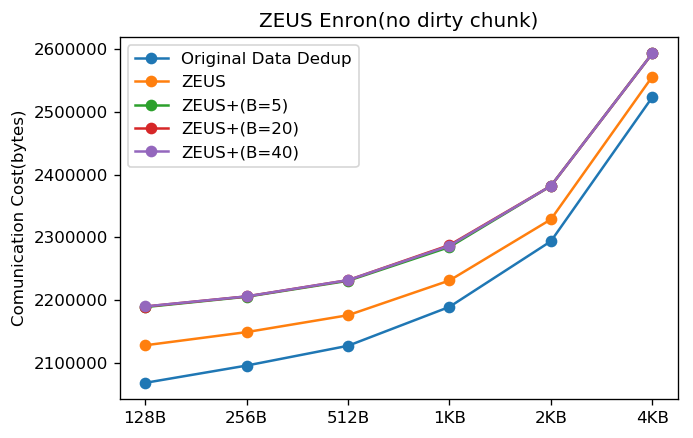

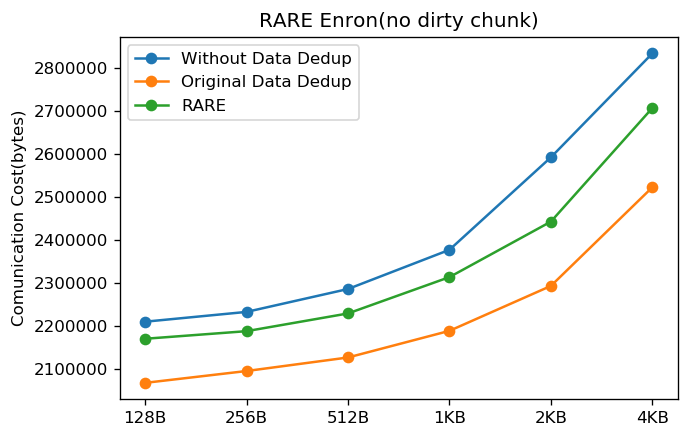

In [14]:
no_dirty = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
no_dirty_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)


%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(no dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(no dirty chunk)')
plt.show()

In [15]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs.clear()
zeus_costs.clear()
zeus5_costs.clear()
zeus20_costs.clear()
zeus40_costs.clear()

no_dedup_costs.clear()
origin_dedup_costs.clear()
rare_costs.clear()

# 10% dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(128, False, True, 0))
zeus_costs.append(cal_commu_cost(128, True, True, 0))
zeus5_costs.append(cal_commu_cost(128, True, True, 5))
zeus20_costs.append(cal_commu_cost(128, True, True, 20))
zeus40_costs.append(cal_commu_cost(128, True, True, 40))

no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, True))
rare_costs.append(rare_cost(128, True, True, True))

dirty original dedup with chunk size: 128 bytes, dedup times: 1010, check times: 17270, dedup percentage: 5.848292 %
dirty ZEUS with chunk size: 128 bytes, dedup times: 548, check times: 17270, dedup percentage: 3.173133 %
dirty ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 164, check times: 17270, dedup percentage: 0.949624 %
dirty ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 161, check times: 17270, dedup percentage: 0.932252 %
dirty ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 162, check times: 17270, dedup percentage: 0.938043 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 17270, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 128 bytes, dedup times: 1010, check times: 17270, dedup percentage: 5.848292 %
dirty RARE with chunk size: 128 bytes, dedup times: 265, check times: 17270, dedup percentage: 1.534453 %


In [16]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(256, False, True, 0))
zeus_costs.append(cal_commu_cost(256, True, True, 0))
zeus5_costs.append(cal_commu_cost(256, True, True, 5))
zeus20_costs.append(cal_commu_cost(256, True, True, 20))
zeus40_costs.append(cal_commu_cost(256, True, True, 40))
no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, True))
rare_costs.append(rare_cost(256, True, True, True))

dirty original dedup with chunk size: 256 bytes, dedup times: 492, check times: 8724, dedup percentage: 5.639615 %
dirty ZEUS with chunk size: 256 bytes, dedup times: 290, check times: 8724, dedup percentage: 3.324163 %
dirty ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 110, check times: 8724, dedup percentage: 1.260890 %
dirty ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 108, check times: 8724, dedup percentage: 1.237964 %
dirty ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 108, check times: 8724, dedup percentage: 1.237964 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 8724, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 256 bytes, dedup times: 492, check times: 8724, dedup percentage: 5.639615 %
dirty RARE with chunk size: 256 bytes, dedup times: 142, check times: 8724, dedup percentage: 1.627694 %


In [17]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(512, False, True, 0))
zeus_costs.append(cal_commu_cost(512, True, True, 0))
zeus5_costs.append(cal_commu_cost(512, True, True, 5))
zeus20_costs.append(cal_commu_cost(512, True, True, 20))
zeus40_costs.append(cal_commu_cost(512, True, True, 40))
no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, True))
rare_costs.append(rare_cost(512, True, True, True))

dirty original dedup with chunk size: 512 bytes, dedup times: 288, check times: 4466, dedup percentage: 6.448724 %
dirty ZEUS with chunk size: 512 bytes, dedup times: 196, check times: 4466, dedup percentage: 4.388715 %
dirty ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 107, check times: 4466, dedup percentage: 2.395880 %
dirty ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 105, check times: 4466, dedup percentage: 2.351097 %
dirty ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 105, check times: 4466, dedup percentage: 2.351097 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 4466, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 512 bytes, dedup times: 288, check times: 4466, dedup percentage: 6.448724 %
dirty RARE with chunk size: 512 bytes, dedup times: 83, check times: 4466, dedup percentage: 1.858486 %


In [18]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(1024, False, True, 0))
zeus_costs.append(cal_commu_cost(1024, True, True, 0))
zeus5_costs.append(cal_commu_cost(1024, True, True, 5))
zeus20_costs.append(cal_commu_cost(1024, True, True, 20))
zeus40_costs.append(cal_commu_cost(1024, True, True, 40))
no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, True))
rare_costs.append(rare_cost(1024, True, True, True))

dirty original dedup with chunk size: 1024 bytes, dedup times: 180, check times: 2322, dedup percentage: 7.751938 %
dirty ZEUS with chunk size: 1024 bytes, dedup times: 139, check times: 2322, dedup percentage: 5.986219 %
dirty ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 89, check times: 2322, dedup percentage: 3.832903 %
dirty ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 88, check times: 2322, dedup percentage: 3.789836 %
dirty ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 88, check times: 2322, dedup percentage: 3.789836 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 2322, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 1024 bytes, dedup times: 180, check times: 2322, dedup percentage: 7.751938 %
dirty RARE with chunk size: 1024 bytes, dedup times: 60, check times: 2322, dedup percentage: 2.583979 %


In [19]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(2048, False, True, 0))
zeus_costs.append(cal_commu_cost(2048, True, True, 0))
zeus5_costs.append(cal_commu_cost(2048, True, True, 5))
zeus20_costs.append(cal_commu_cost(2048, True, True, 20))
zeus40_costs.append(cal_commu_cost(2048, True, True, 40))

no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, True))
rare_costs.append(rare_cost(2048, True, True, True))

dirty original dedup with chunk size: 2048 bytes, dedup times: 143, check times: 1266, dedup percentage: 11.295419 %
dirty ZEUS with chunk size: 2048 bytes, dedup times: 126, check times: 1266, dedup percentage: 9.952607 %
dirty ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 104, check times: 1266, dedup percentage: 8.214850 %
dirty ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 104, check times: 1266, dedup percentage: 8.214850 %
dirty ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 103, check times: 1266, dedup percentage: 8.135861 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 1266, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 2048 bytes, dedup times: 143, check times: 1266, dedup percentage: 11.295419 %
dirty RARE with chunk size: 2048 bytes, dedup times: 61, check times: 1266, dedup percentage: 4.818325 %


In [20]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(4096, False, True, 0))
zeus_costs.append(cal_commu_cost(4096, True, True, 0))
zeus5_costs.append(cal_commu_cost(4096, True, True, 5))
zeus20_costs.append(cal_commu_cost(4096, True, True, 20))
zeus40_costs.append(cal_commu_cost(4096, True, True, 40))

no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, True))
rare_costs.append(rare_cost(4096, True, True, True))

dirty original dedup with chunk size: 4096 bytes, dedup times: 76, check times: 692, dedup percentage: 10.982659 %
dirty ZEUS with chunk size: 4096 bytes, dedup times: 68, check times: 692, dedup percentage: 9.826590 %
dirty ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 59, check times: 692, dedup percentage: 8.526012 %
dirty ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 59, check times: 692, dedup percentage: 8.526012 %
dirty ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 59, check times: 692, dedup percentage: 8.526012 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 692, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 4096 bytes, dedup times: 76, check times: 692, dedup percentage: 10.982659 %
dirty RARE with chunk size: 4096 bytes, dedup times: 40, check times: 692, dedup percentage: 5.780347 %


Origin Data Dedup: [2081280, 2107392, 2139136, 2193408, 2299904, 2523136]
ZEUS:              [2140416, 2159104, 2186240, 2235392, 2334720, 2555904]
ZEUS+(B=5):        [2189568, 2205184, 2231808, 2286592, 2379776, 2592768]
ZEUS+(B=20):       [2189952, 2205696, 2232832, 2287616, 2379776, 2592768]
ZEUS+(B=40):       [2189824, 2205696, 2232832, 2287616, 2381824, 2592768]
-------------
Without Data Dedup: [2210560, 2233344, 2286592, 2377728, 2592768, 2834432]
Rare:               [2176640, 2196992, 2244096, 2316288, 2467840, 2670592]
Origin Data Dedup:  [2081280, 2107392, 2139136, 2193408, 2299904, 2523136]


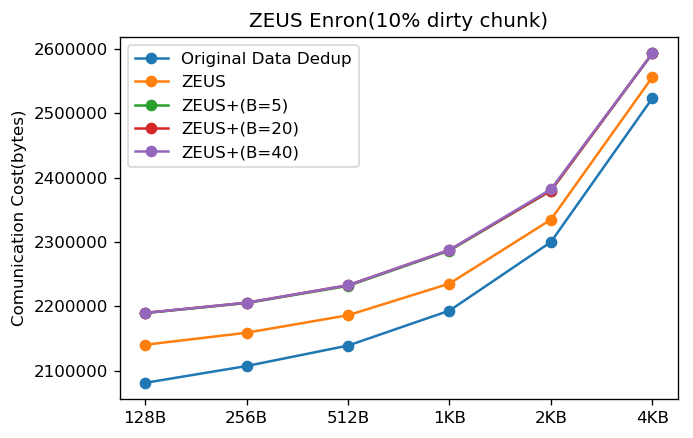

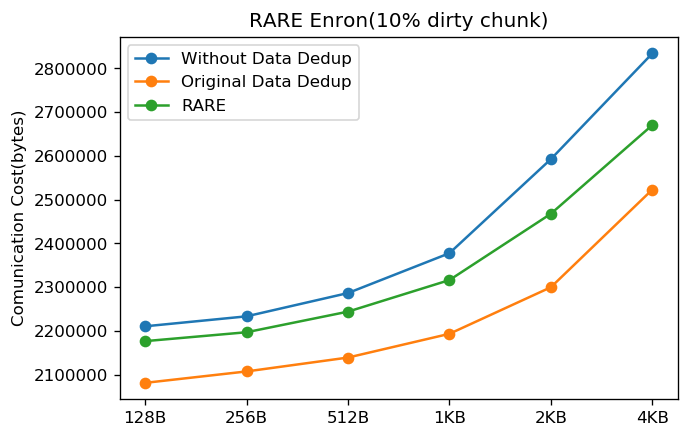

In [21]:
dirty10 = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
dirty10_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(10% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(10% dirty chunk)')
plt.show()

In [22]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs.clear()
zeus_costs.clear()
zeus5_costs.clear()
zeus20_costs.clear()
zeus40_costs.clear()

no_dedup_costs.clear()
origin_dedup_costs.clear()
rare_costs.clear()

# 25% dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(128, False, True, 0))
zeus_costs.append(cal_commu_cost(128, True, True, 0))
zeus5_costs.append(cal_commu_cost(128, True, True, 5))
zeus20_costs.append(cal_commu_cost(128, True, True, 20))
zeus40_costs.append(cal_commu_cost(128, True, True, 40))
no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, True))
rare_costs.append(rare_cost(128, True, True, True))

dirty original dedup with chunk size: 128 bytes, dedup times: 884, check times: 17270, dedup percentage: 5.118703 %
dirty ZEUS with chunk size: 128 bytes, dedup times: 451, check times: 17270, dedup percentage: 2.611465 %
dirty ZEUS having threshold 5, with chunk size: 128 bytes, dedup times: 169, check times: 17270, dedup percentage: 0.978576 %
dirty ZEUS having threshold 20, with chunk size: 128 bytes, dedup times: 162, check times: 17270, dedup percentage: 0.938043 %
dirty ZEUS having threshold 40, with chunk size: 128 bytes, dedup times: 164, check times: 17270, dedup percentage: 0.949624 %
no dedup with chunk size: 128 bytes, dedup times: 0, check times: 17270, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 128 bytes, dedup times: 884, check times: 17270, dedup percentage: 5.118703 %
dirty RARE with chunk size: 128 bytes, dedup times: 216, check times: 17270, dedup percentage: 1.250724 %


In [23]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(256, False, True, 0))
zeus_costs.append(cal_commu_cost(256, True, True, 0))
zeus5_costs.append(cal_commu_cost(256, True, True, 5))
zeus20_costs.append(cal_commu_cost(256, True, True, 20))
zeus40_costs.append(cal_commu_cost(256, True, True, 40))
no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, True))
rare_costs.append(rare_cost(256, True, True, True))

dirty original dedup with chunk size: 256 bytes, dedup times: 410, check times: 8724, dedup percentage: 4.699679 %
dirty ZEUS with chunk size: 256 bytes, dedup times: 218, check times: 8724, dedup percentage: 2.498854 %
dirty ZEUS having threshold 5, with chunk size: 256 bytes, dedup times: 107, check times: 8724, dedup percentage: 1.226502 %
dirty ZEUS having threshold 20, with chunk size: 256 bytes, dedup times: 108, check times: 8724, dedup percentage: 1.237964 %
dirty ZEUS having threshold 40, with chunk size: 256 bytes, dedup times: 108, check times: 8724, dedup percentage: 1.237964 %
no dedup with chunk size: 256 bytes, dedup times: 0, check times: 8724, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 256 bytes, dedup times: 410, check times: 8724, dedup percentage: 4.699679 %
dirty RARE with chunk size: 256 bytes, dedup times: 103, check times: 8724, dedup percentage: 1.180651 %


In [24]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(512, False, True, 0))
zeus_costs.append(cal_commu_cost(512, True, True, 0))
zeus5_costs.append(cal_commu_cost(512, True, True, 5))
zeus20_costs.append(cal_commu_cost(512, True, True, 20))
zeus40_costs.append(cal_commu_cost(512, True, True, 40))
no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, True))
rare_costs.append(rare_cost(512, True, True, True))

dirty original dedup with chunk size: 512 bytes, dedup times: 257, check times: 4466, dedup percentage: 5.754590 %
dirty ZEUS with chunk size: 512 bytes, dedup times: 170, check times: 4466, dedup percentage: 3.806538 %
dirty ZEUS having threshold 5, with chunk size: 512 bytes, dedup times: 110, check times: 4466, dedup percentage: 2.463054 %
dirty ZEUS having threshold 20, with chunk size: 512 bytes, dedup times: 107, check times: 4466, dedup percentage: 2.395880 %
dirty ZEUS having threshold 40, with chunk size: 512 bytes, dedup times: 106, check times: 4466, dedup percentage: 2.373489 %
no dedup with chunk size: 512 bytes, dedup times: 0, check times: 4466, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 512 bytes, dedup times: 257, check times: 4466, dedup percentage: 5.754590 %
dirty RARE with chunk size: 512 bytes, dedup times: 85, check times: 4466, dedup percentage: 1.903269 %


In [25]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(1024, False, True, 0))
zeus_costs.append(cal_commu_cost(1024, True, True, 0))
zeus5_costs.append(cal_commu_cost(1024, True, True, 5))
zeus20_costs.append(cal_commu_cost(1024, True, True, 20))
zeus40_costs.append(cal_commu_cost(1024, True, True, 40))
no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, True))
rare_costs.append(rare_cost(1024, True, True, True))

dirty original dedup with chunk size: 1024 bytes, dedup times: 161, check times: 2322, dedup percentage: 6.933678 %
dirty ZEUS with chunk size: 1024 bytes, dedup times: 122, check times: 2322, dedup percentage: 5.254091 %
dirty ZEUS having threshold 5, with chunk size: 1024 bytes, dedup times: 87, check times: 2322, dedup percentage: 3.746770 %
dirty ZEUS having threshold 20, with chunk size: 1024 bytes, dedup times: 88, check times: 2322, dedup percentage: 3.789836 %
dirty ZEUS having threshold 40, with chunk size: 1024 bytes, dedup times: 87, check times: 2322, dedup percentage: 3.746770 %
no dedup with chunk size: 1024 bytes, dedup times: 0, check times: 2322, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 1024 bytes, dedup times: 161, check times: 2322, dedup percentage: 6.933678 %
dirty RARE with chunk size: 1024 bytes, dedup times: 59, check times: 2322, dedup percentage: 2.540913 %


In [26]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(2048, False, True, 0))
zeus_costs.append(cal_commu_cost(2048, True, True, 0))
zeus5_costs.append(cal_commu_cost(2048, True, True, 5))
zeus20_costs.append(cal_commu_cost(2048, True, True, 20))
zeus40_costs.append(cal_commu_cost(2048, True, True, 40))
no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, True))
rare_costs.append(rare_cost(2048, True, True, True))

dirty original dedup with chunk size: 2048 bytes, dedup times: 139, check times: 1266, dedup percentage: 10.979463 %
dirty ZEUS with chunk size: 2048 bytes, dedup times: 122, check times: 1266, dedup percentage: 9.636651 %
dirty ZEUS having threshold 5, with chunk size: 2048 bytes, dedup times: 103, check times: 1266, dedup percentage: 8.135861 %
dirty ZEUS having threshold 20, with chunk size: 2048 bytes, dedup times: 102, check times: 1266, dedup percentage: 8.056872 %
dirty ZEUS having threshold 40, with chunk size: 2048 bytes, dedup times: 102, check times: 1266, dedup percentage: 8.056872 %
no dedup with chunk size: 2048 bytes, dedup times: 0, check times: 1266, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 2048 bytes, dedup times: 139, check times: 1266, dedup percentage: 10.979463 %
dirty RARE with chunk size: 2048 bytes, dedup times: 58, check times: 1266, dedup percentage: 4.581359 %


In [27]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(4096, False, True, 0))
zeus_costs.append(cal_commu_cost(4096, True, True, 0))
zeus5_costs.append(cal_commu_cost(4096, True, True, 5))
zeus20_costs.append(cal_commu_cost(4096, True, True, 20))
zeus40_costs.append(cal_commu_cost(4096, True, True, 40))
no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, True))
rare_costs.append(rare_cost(4096, True, True, True))

dirty original dedup with chunk size: 4096 bytes, dedup times: 74, check times: 692, dedup percentage: 10.693642 %
dirty ZEUS with chunk size: 4096 bytes, dedup times: 66, check times: 692, dedup percentage: 9.537572 %
dirty ZEUS having threshold 5, with chunk size: 4096 bytes, dedup times: 59, check times: 692, dedup percentage: 8.526012 %
dirty ZEUS having threshold 20, with chunk size: 4096 bytes, dedup times: 59, check times: 692, dedup percentage: 8.526012 %
dirty ZEUS having threshold 40, with chunk size: 4096 bytes, dedup times: 59, check times: 692, dedup percentage: 8.526012 %
no dedup with chunk size: 4096 bytes, dedup times: 0, check times: 692, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 4096 bytes, dedup times: 74, check times: 692, dedup percentage: 10.693642 %
dirty RARE with chunk size: 4096 bytes, dedup times: 28, check times: 692, dedup percentage: 4.046243 %


Origin Data Dedup: [2097408, 2128384, 2155008, 2212864, 2308096, 2531328]
ZEUS:              [2152832, 2177536, 2199552, 2252800, 2342912, 2564096]
ZEUS+(B=5):        [2188928, 2205952, 2230272, 2288640, 2381824, 2592768]
ZEUS+(B=20):       [2189824, 2205696, 2231808, 2287616, 2383872, 2592768]
ZEUS+(B=40):       [2189568, 2205696, 2232320, 2288640, 2383872, 2592768]
-------------
Without Data Dedup: [2210560, 2233344, 2286592, 2377728, 2592768, 2834432]
Rare:               [2182912, 2206976, 2243072, 2317312, 2473984, 2719744]
Origin Data Dedup:  [2097408, 2128384, 2155008, 2212864, 2308096, 2531328]


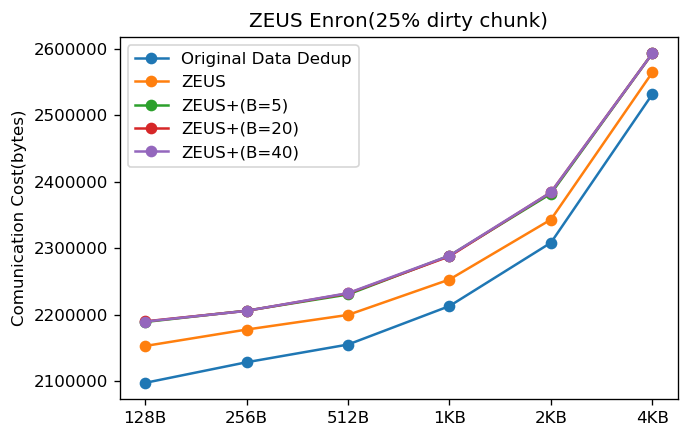

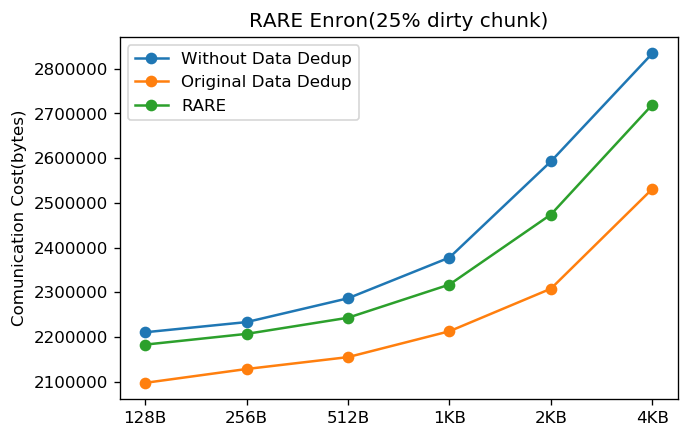

In [28]:
dirty25 = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
dirty25_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(25% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(25% dirty chunk)')
plt.show()

no dirty chunk					 10% dirty chunk				 25% dirty chunk
ZEUS
['128B', '256B', '512B', '1KB', '2KB', '4KB']
[2068352, 2095872, 2127360, 2189312, 2293760, 2523136] [2081280, 2107392, 2139136, 2193408, 2299904, 2523136] [2097408, 2128384, 2155008, 2212864, 2308096, 2531328]
[2128128, 2149120, 2176000, 2231296, 2328576, 2555904] [2140416, 2159104, 2186240, 2235392, 2334720, 2555904] [2152832, 2177536, 2199552, 2252800, 2342912, 2564096]
[2188928, 2205440, 2230784, 2284544, 2381824, 2592768] [2189568, 2205184, 2231808, 2286592, 2379776, 2592768] [2188928, 2205952, 2230272, 2288640, 2381824, 2592768]
[2189824, 2205952, 2231808, 2287616, 2381824, 2592768] [2189952, 2205696, 2232832, 2287616, 2379776, 2592768] [2189824, 2205696, 2231808, 2287616, 2383872, 2592768]
[2189952, 2205952, 2231808, 2286592, 2381824, 2592768] [2189824, 2205696, 2232832, 2287616, 2381824, 2592768] [2189568, 2205696, 2232320, 2288640, 2383872, 2592768]
--------------
RARE
[2210560, 2233344, 2286592, 2377728, 2592768, 28

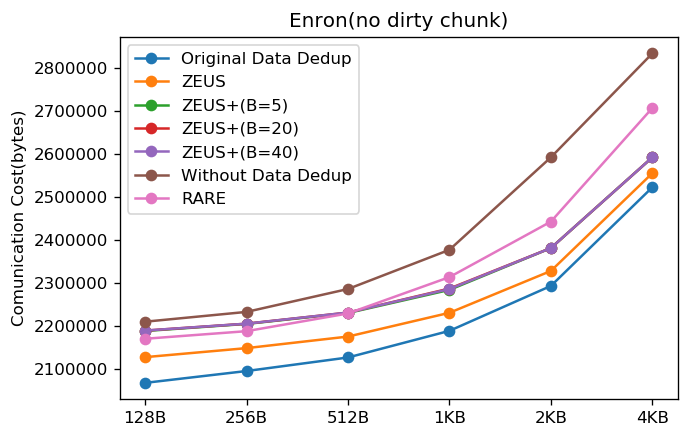

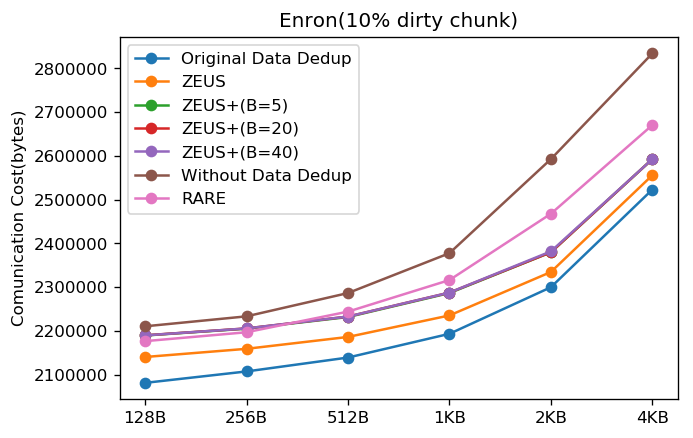

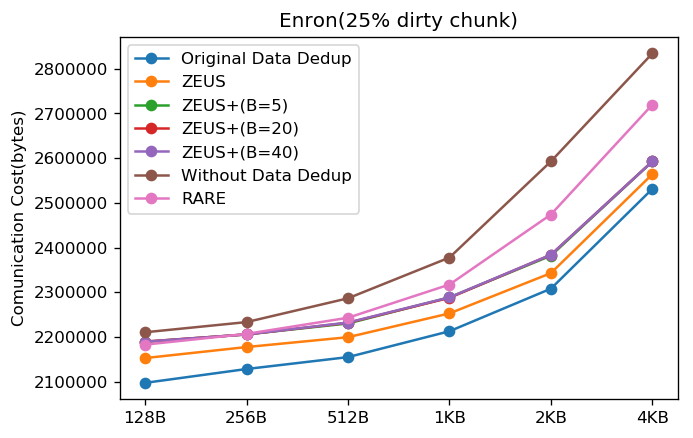

In [29]:
print('no dirty chunk\t\t\t\t\t', '10% dirty chunk\t\t\t\t', '25% dirty chunk')
print('ZEUS')
print(x)
for i in range(len(no_dirty)):
    print(no_dirty[i], dirty10[i], dirty25[i])
print('--------------')
print('RARE')
for i in range(len(no_dirty_rare)):
    print(no_dirty_rare[i], dirty10_rare[i], dirty25_rare[i])

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, no_dirty[0],  '-o', label = 'Original Data Dedup')
plt.plot(x, no_dirty[1],  '-o', label = 'ZEUS')
plt.plot(x, no_dirty[2],  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, no_dirty[3],  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, no_dirty[4],  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, no_dirty_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, no_dirty_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(no dirty chunk)')
plt.show()
    
plt.figure(dpi = 120)
plt.plot(x, dirty10[0],  '-o', label = 'Original Data Dedup')
plt.plot(x, dirty10[1],  '-o', label = 'ZEUS')
plt.plot(x, dirty10[2],  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, dirty10[3],  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, dirty10[4],  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, dirty10_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, dirty10_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(10% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, dirty25_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, dirty25_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(25% dirty chunk)')
plt.show()

# plt.subplot(131)
# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, no_dirty[0],  '-o', label = 'Original Data Dedup')
# plt.plot(x, no_dirty[1],  '-o', label = 'ZEUS')
# plt.plot(x, no_dirty[2],  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, no_dirty[3],  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, no_dirty[4],  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(no dirty chunk)')
# plt.show()

# plt.subplot(132)
# plt.figure(dpi = 120)
# plt.plot(x, dirty10[0],  '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty10[1],  '-o', label = 'ZEUS')
# plt.plot(x, dirty10[2],  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, dirty10[3],  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, dirty10[4],  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(10% dirty chunk)')
# plt.show()

# plt.subplot(133)
# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
# plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
# plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(25% dirty chunk)')
# plt.show()

# plt.subplot(131)
# plt.figure(dpi = 120)
# plt.plot(x, no_dirty_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, no_dirty_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, no_dirty_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RARE Enron(no dirty chunk)')
# plt.show()

# plt.subplot(232)
# plt.figure(dpi = 120)
# plt.plot(x, dirty10_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, dirty10_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty10_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RAER Enron(10% dirty chunk)')
# plt.show()

# plt.subplot(233)
# plt.figure(dpi = 120)
# plt.plot(x, dirty25_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, dirty25_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty25_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RARE Enron(25% dirty chunk)')
# plt.show()

In [30]:
'''
This program doing duplication testing. Always change the UChunksize for the simulation.
'''

import os
import hashlib

import random
import matplotlib.pyplot as plt
import numpy as np
 
#a = random.sample(range(1, 1500), 1000);  # creat 1000 random variables of specified range
#print(a);
#print(a[0])

################## get the path to the database
out = 1;
#path1 = os.getcwd();
# path = '/home/sarada/work/work/prog/side2/clouddatabase/';   # change database_XXX into 1K 2K 4K and also Uchunksize accordingly
#print(path);
Uchunksize1 = 128;
Uchunksize2 = 256;
Uchunksize3 = 512;
Uchunksize4 = 1024;
Uchunksize5 = 2048;
Uchunksize6 = 4192;
Cloud_Store1 = [];
Cloud_Store2 = [];
Cloud_Store3 = [];
Cloud_Store4 = [];
Cloud_Store5 = [];
Cloud_Store6 = [];
movValue = 0;
inValue = 0;


###################### this set of codes select 1000 files randomly from the database 1 and store them in the cloud store which has only hash values
for filename in upload_files:
    #b = random.random();
  #if b > .5:
  # if inValue < 500:
    fin1 = open(filename, 'r');
    wi1 = 0;
    while wi1 == 0:
        line1 = fin1.read(Uchunksize1)
        while line1 != '':
            Cloud_Store1.append(str([hashlib.sha512(line1.encode('utf-8')).digest()])) 
            line1 = fin1.read(Uchunksize1)
            if len(line1) == 0:
                wi1 = 1
    fin1.close();

    fin2 = open(filename, 'r');
    wi2 = 0;
    while wi2 == 0:
        line2 = fin2.read(Uchunksize2)
        while line2 != '':
            Cloud_Store2.append(str([hashlib.sha512(line2.encode('utf-8')).digest()])) 
            line2 = fin2.read(Uchunksize2)
            if len(line2) == 0:
                wi2 = 1
    fin2.close();

    fin3 = open(filename, 'r');
    wi3 = 0;
    while wi3 == 0:
        line3 = fin3.read(Uchunksize3)
        while line3 != '':
            Cloud_Store3.append(str([hashlib.sha512(line3.encode('utf-8')).digest()])) 
            line3 = fin3.read(Uchunksize3)
            if len(line3) == 0:
                wi3 = 1
    fin3.close();

    fin4 = open(filename, 'r');
    wi4 = 0;
    while wi4 == 0:
        line4 = fin4.read(Uchunksize4)
        while line4 != '':
            Cloud_Store4.append(str([hashlib.sha512(line4.encode('utf-8')).digest()])) 
            line4 = fin4.read(Uchunksize4)
            if len(line4) == 0:
                wi4 = 1
    fin4.close();

    fin5 = open(filename, 'r');
    wi5 = 0;
    while wi5 == 0:
        line5 = fin5.read(Uchunksize5)
        while line5 != '':
            Cloud_Store5.append(str([hashlib.sha512(line5.encode('utf-8')).digest()])) 
            line5 = fin5.read(Uchunksize5)
            if len(line5) == 0:
                wi5 = 1
    fin5.close();

    fin6 = open(filename, 'r');
    wi6 = 0;
    while wi6 == 0:
        line6 = fin6.read(Uchunksize6)
        while line6 != '':
            Cloud_Store6.append(str([hashlib.sha512(line6.encode('utf-8')).digest()])) 
            line6 = fin6.read(Uchunksize6)
            if len(line6) == 0:
                wi6 = 1
    fin6.close();
    inValue = inValue + 1;

#print ("Cloud data", len(Cloud_Store1))
#print ("hash value size", len(Cloud_Store1[1]))
#print ("Cloud data", len(Cloud_Store2))
#print ("hash value size", len(Cloud_Store2[1]))
#print ("Cloud data", len(Cloud_Store3))
#print ("hash value size", len(Cloud_Store3[1]))
#print ("Cloud data", len(Cloud_Store4))
#print ("hash value size", len(Cloud_Store4[1]))
#print ("Cloud data", len(Cloud_Store5))
#print ("hash value size", len(Cloud_Store5[1]))
#print ("Cloud data", len(Cloud_Store6))
#print ("hash value size", len(Cloud_Store6[1]))




######################################## without flag#######################################3
###client Checking hash values with the cloud server with Normal Data Deduplication  

def HashSendToCloudNormalDatadedpulication_without(receivedList, Cloud_Store,rand_file_number):
    out1 = 0;
    if not receivedList in Cloud_Store:    
        out1 = 1;
    return out1;


#client Checking hash values with the cloud server with RPX method 

def HashSendToCloudRpX_without(receivedList,Cloud_Store,rand_file_number):
    out1 = 0;
    out2 = 0;
    if not receivedList[0] in Cloud_Store:  
        out1 = 1;
    if not receivedList[1] in Cloud_Store:  
        out2 = 1;
    if out1 == 1 and out2 ==1:
       TotalOut = 2; 
    else: TotalOut = 1;
     
    return TotalOut;


#client Checking hash values with the cloud server with RPX with B =5 

def HashSendToCloudRpXPlus5_without(receivedList,Cloud_Store,rand_file_number):
    B= 5;
    out1 = 0;
    out2 = 0;
    if not receivedList[0] in Cloud_Store:  
        out1 = 1;
    else:
       if rand_file_number <= B:  
          out1 = 1;         
    if not receivedList[1] in Cloud_Store:  
        out2 = 1;
    else:
       if rand_file_number <= B:  
          out2 = 1; 
    if out1 == 1 and out2 ==1:
       TotalOut = 2; 
    else: TotalOut = 1;
   
    return TotalOut;

#client Checking hash values with the cloud server with RPX with B =10 

def HashSendToCloudRpXPlus10_without(receivedList,Cloud_Store,rand_file_number):
    B = 20;
    out1 = 0;
    out2 = 0;
    if not receivedList[0] in Cloud_Store:  
        out1 = 1;
    else:
       if rand_file_number <= B:  
          out1 = 1;         
    if not receivedList[1] in Cloud_Store:  
        out2 = 1;
    else:
       if rand_file_number <= B:  
          out2 = 1; 
    if out1 == 1 and out2 ==1:
       TotalOut = 2; 
    else: TotalOut = 1;
   
    return TotalOut;

#client Checking hash values with the cloud server with RPX with B =20 

def HashSendToCloudRpXPlus20_without(receivedList,Cloud_Store,rand_file_number):
    B = 40
    out1 = 0;
    out2 = 0;
    if not receivedList[0] in Cloud_Store:  
        out1 = 1;
    else:
       if rand_file_number <= B:  
          out1 = 1;         
    if not receivedList[1] in Cloud_Store:  
        out2 = 1;
    else:
       if rand_file_number <= B:  
          out2 = 1; 
    if out1 == 1 and out2 ==1:
       TotalOut = 2; 
    else: TotalOut = 1;
   
    return TotalOut;



###############################################################################################################3
########################################## with flag   #######################################################


###client Checking hash values with the cloud server with Normal Data Deduplication 

def HashSendToCloudNormalDatadedpulication(receivedList, Cloud_Store,flag,rand_file_number):
    out1 = 0;
    if flag == 1:
        out1 = 1;
    else:
        if not receivedList in Cloud_Store:    
            out1 = 1;
    return out1;

#client Checking hash values with the cloud server with RPX method 
def HashSendToCloudRpX(receivedList,Cloud_Store,flag,rand_file_number):
   out1 = 0;
   out2 = 0;
   if flag == 1:
     TotalOut = 2;
   else:
    #print (receivedList[0]);
    #print (receivedList[1]);
    if not receivedList[0] in Cloud_Store:  
        
        #Cloud_Store.append(receivedList[0])
        out1 = 1;
        #print "out 1 is 1"
    if not receivedList[1] in Cloud_Store:  
        #Cloud_Store.append(receivedList[1])
        out2 = 1;
        #print "out 2 is 2"
    if out1 == 1 and out2 ==1:
       TotalOut = 2; 
    else: TotalOut = 1;
     
    return TotalOut;


#client Checking hash values with the cloud server with RPX with B =5 

def HashSendToCloudRpXPlus5(receivedList,Cloud_Store,flag,rand_file_number):
    B= 5;
    out1 = 0;
    out2 = 0;
    if flag == 1:
     TotalOut = 2;
     #print("TotalOut is two");
    else:
     #print("TotalOut is one");
     if not receivedList[0] in Cloud_Store:  
         out1 = 1;
     else:
        if rand_file_number <= B:  
           out1 = 1;         
     if not receivedList[1] in Cloud_Store:  
         out2 = 1;
     else:
        if rand_file_number <= B:  
           out2 = 1; 
     if out1 == 1 and out2 ==1:
        TotalOut = 2; 
     else: TotalOut = 1;
    #print(TotalOut);
    return TotalOut;

#client Checking hash values with the cloud server with RPX with B =10 

def HashSendToCloudRpXPlus10(receivedList,Cloud_Store,flag,rand_file_number):
   B = 20;
   out1 = 0;
   out2 = 0;
   if flag == 1:
    TotalOut = 2;
   else:
    if not receivedList[0] in Cloud_Store:  
        out1 = 1;
    else:
       if rand_file_number <= B:  
          out1 = 1;         
    if not receivedList[1] in Cloud_Store:  
        out2 = 1;
    else:
       if rand_file_number <= B:  
          out2 = 1; 
    if out1 == 1 and out2 ==1:
       TotalOut = 2; 
    else: TotalOut = 1;
   
   return TotalOut;


#client Checking hash values with the cloud server with RPX with B =20 

def HashSendToCloudRpXPlus20(receivedList,Cloud_Store,flag,rand_file_number):
   B = 40
   out1 = 0;
   out2 = 0;
   if flag == 1:
    TotalOut = 2;
   else:
    if not receivedList[0] in Cloud_Store:  
        out1 = 1;
    else:
       if rand_file_number <= B:  
          out1 = 1;         
    if not receivedList[1] in Cloud_Store:  
        out2 = 1;
    else:
       if rand_file_number <= B:  
          out2 = 1; 
    if out1 == 1 and out2 ==1:
       TotalOut = 2; 
    else: TotalOut = 1;
   
   return TotalOut;
################################################################################################

communication_cost_NormalDatadedpulication_1_without = 0;
communication_cost_rpx_1_without = 0;
communication_cost_rpxPlus5_1_without = 0;
communication_cost_rpxPlus10_1_without = 0;
communication_cost_rpxPlus20_1_without = 0;

communication_cost_NormalDatadedpulication_1 = 0;
communication_cost_rpx_1 = 0;
communication_cost_rpxPlus5_1 = 0;
communication_cost_rpxPlus10_1 = 0;
communication_cost_rpxPlus20_1 = 0;


communication_cost_NormalDatadedpulication_2_without = 0;
communication_cost_rpx_2_without = 0;
communication_cost_rpxPlus5_2_without = 0;
communication_cost_rpxPlus10_2_without = 0;
communication_cost_rpxPlus20_2_without = 0;

communication_cost_NormalDatadedpulication_2 = 0;
communication_cost_rpx_2 = 0;
communication_cost_rpxPlus5_2 = 0;
communication_cost_rpxPlus10_2 = 0;
communication_cost_rpxPlus20_2 = 0;


communication_cost_NormalDatadedpulication_3_without = 0;
communication_cost_rpx_3_without = 0;
communication_cost_rpxPlus5_3_without = 0;
communication_cost_rpxPlus10_3_without = 0;
communication_cost_rpxPlus20_3_without = 0;

communication_cost_NormalDatadedpulication_3 = 0;
communication_cost_rpx_3 = 0;
communication_cost_rpxPlus5_3 = 0;
communication_cost_rpxPlus10_3 = 0;
communication_cost_rpxPlus20_3 = 0;


communication_cost_NormalDatadedpulication_4_without = 0;
communication_cost_rpx_4_without = 0;
communication_cost_rpxPlus5_4_without = 0;
communication_cost_rpxPlus10_4_without = 0;
communication_cost_rpxPlus20_4_without = 0;

communication_cost_NormalDatadedpulication_4 = 0;
communication_cost_rpx_4 = 0;
communication_cost_rpxPlus5_4 = 0;
communication_cost_rpxPlus10_4 = 0;
communication_cost_rpxPlus20_4 = 0;


communication_cost_NormalDatadedpulication_5_without = 0;
communication_cost_rpx_5_without = 0;
communication_cost_rpxPlus5_5_without = 0;
communication_cost_rpxPlus10_5_without = 0;
communication_cost_rpxPlus20_5_without = 0;

communication_cost_NormalDatadedpulication_5 = 0;
communication_cost_rpx_5 = 0;
communication_cost_rpxPlus5_5 = 0;
communication_cost_rpxPlus10_5 = 0;
communication_cost_rpxPlus20_5 = 0;


communication_cost_NormalDatadedpulication_6_without = 0;
communication_cost_rpx_6_without = 0;
communication_cost_rpxPlus5_6_without = 0;
communication_cost_rpxPlus10_6_without = 0;
communication_cost_rpxPlus20_6_without = 0;

communication_cost_NormalDatadedpulication_6 = 0;
communication_cost_rpx_6 = 0;
communication_cost_rpxPlus5_6 = 0;
communication_cost_rpxPlus10_6 = 0;
communication_cost_rpxPlus20_6 = 0;









##############send 
#path1 = os.getcwd();
# path1 = '/home/sarada/work/work/prog/side2/attack/';
send_to_cloud1 = [];
send_to_cloud2 = [];
send_to_cloud3 = [];
send_to_cloud4 = [];
send_to_cloud5 = [];
send_to_cloud6 = [];
inline1 = 1;
inline2 = 1;
inline3 = 1;
inline4 = 1;
inline5 = 1;
inline6 = 1;

bad_packet = 4; # 10 for 10 percent, 5 for 20 percent, 4 for 25 percent and 100 for 1percent
rand_value = 50;

Number_of_packets_1 =  0
flag_1 = 0;
Number_of_packets_2 =  0
flag_2 = 0;
Number_of_packets_3 =  0
flag_3 = 0;
Number_of_packets_4 =  0
flag_4 = 0;
Number_of_packets_5 =  0
flag_5 = 0;
Number_of_packets_6 =  0
flag_6 = 0;
Data_size_1 = [];
Data_size_2 = [];
Data_size_3 = [];
Data_size_4 = [];
Data_size_5 = [];
Data_size_6 = [];


meta_data_1 = [];
meta_data_1_1 = [];
meta_data_variable_1 = 0;

number_of_bad_packet_1 = 0;
number_of_bad_packet_2 = 0;
number_of_bad_packet_3 = 0;
number_of_bad_packet_4 = 0;
number_of_bad_packet_5 = 0;
number_of_bad_packet_6 = 0;

for filename in check_files:
     ###############################################################
     fin1 = open(filename, 'r');
     #meta_data_1.append([meta_data_1_1.append(fin1)]);
     wi1 = 0;
     while wi1 == 0:
        line1 = fin1.read(Uchunksize1)
        Number_of_packets_1 = Number_of_packets_1 + 1;
        
        while line1 != '':
          #print("i am here");
          rand_file_number = random.randint(1, rand_value);
          hash_1_1 = str([hashlib.sha512(line1.encode('utf-8')).digest()])
          Data_size_1.append(hash_1_1);
          if inline1 == 1:
          #    print("i am here too");
              send_to_cloud1.append(hash_1_1);
              result_normalDeduplication_1_without = HashSendToCloudNormalDatadedpulication_without(hash_1_1, Cloud_Store1,rand_file_number);
              result_normalDeduplication_1 = HashSendToCloudNormalDatadedpulication(hash_1_1, Cloud_Store1, flag_1, rand_file_number);
              if result_normalDeduplication_1_without == 1:
                communication_cost_NormalDatadedpulication_1_without = communication_cost_NormalDatadedpulication_1_without + Uchunksize1;
            
              if result_normalDeduplication_1 == 1:
                communication_cost_NormalDatadedpulication_1 = communication_cost_NormalDatadedpulication_1 + Uchunksize1;
              inline1 = inline1 + 1;
          else:         
           send_to_cloud1.append(hash_1_1);

           ################### Normal Deduplication ############################
           result_normalDeduplication_1_without = HashSendToCloudNormalDatadedpulication_without(hash_1_1, Cloud_Store1,rand_file_number);
           result_normalDeduplication_1 = HashSendToCloudNormalDatadedpulication(hash_1_1, Cloud_Store1, flag_1, rand_file_number);

           if result_normalDeduplication_1_without == 1:
             communication_cost_NormalDatadedpulication_1_without = communication_cost_NormalDatadedpulication_1_without + Uchunksize1;
           if result_normalDeduplication_1 == 1:
             communication_cost_NormalDatadedpulication_1 = communication_cost_NormalDatadedpulication_1 + Uchunksize1;  
           #print(len(send_to_cloud));
           ################## RPX based deduplication ##############################
           result_rpx_1_without = HashSendToCloudRpX_without(send_to_cloud1, Cloud_Store1,rand_file_number)
           result_rpx_1 = HashSendToCloudRpX(send_to_cloud1, Cloud_Store1, flag_1,rand_file_number)

           if result_rpx_1_without == 1:
             communication_cost_rpx_1_without = communication_cost_rpx_1_without + Uchunksize1;
           else:
             communication_cost_rpx_1_without = communication_cost_rpx_1_without + 2*Uchunksize1; 

           if result_rpx_1 == 1:
             communication_cost_rpx_1 = communication_cost_rpx_1 + Uchunksize1;
           else:
             communication_cost_rpx_1 = communication_cost_rpx_1 + 2*Uchunksize1; 
           ################## RPX Plus 5 based deduplication ##############################
           #print(flag_1);
           result_rpxPlus5_1_without = HashSendToCloudRpXPlus5_without(send_to_cloud1, Cloud_Store1,rand_file_number)
           result_rpxPlus5_1 = HashSendToCloudRpXPlus5(send_to_cloud1, Cloud_Store1, flag_1,rand_file_number)
           #print("result_rpxPlus5_1",result_rpxPlus5_1)
           if result_rpxPlus5_1_without == 1:
             communication_cost_rpxPlus5_1_without = communication_cost_rpxPlus5_1_without + Uchunksize1;
           else:
             communication_cost_rpxPlus5_1_without = communication_cost_rpxPlus5_1_without + 2*Uchunksize1; 

           if result_rpxPlus5_1 == 1:
             communication_cost_rpxPlus5_1 = communication_cost_rpxPlus5_1 + Uchunksize1;
           else:
             communication_cost_rpxPlus5_1 = communication_cost_rpxPlus5_1 + 2*Uchunksize1;
           ################## RPX Plus 10 based deduplication ##############################
           result_rpxPlus10_1_without = HashSendToCloudRpXPlus10_without(send_to_cloud1, Cloud_Store1,rand_file_number)
           result_rpxPlus10_1 = HashSendToCloudRpXPlus10(send_to_cloud1, Cloud_Store1, flag_1,rand_file_number)
           #print("result_rpxPlus10_1",result_rpxPlus10_1) 
           if result_rpxPlus10_1_without == 1:
             communication_cost_rpxPlus10_1_without = communication_cost_rpxPlus10_1_without + Uchunksize1;
           else:
             communication_cost_rpxPlus10_1_without = communication_cost_rpxPlus10_1_without + 2*Uchunksize1;

           if result_rpxPlus10_1 == 1:
             communication_cost_rpxPlus10_1 = communication_cost_rpxPlus10_1 + Uchunksize1;
           else:
             communication_cost_rpxPlus10_1 = communication_cost_rpxPlus10_1 + 2*Uchunksize1; 
           ################## RPX Plus 20 based deduplication ##############################
           result_rpxPlus20_1_without = HashSendToCloudRpXPlus20_without(send_to_cloud1, Cloud_Store1,rand_file_number)
           result_rpxPlus20_1 = HashSendToCloudRpXPlus20(send_to_cloud1, Cloud_Store1, flag_1,rand_file_number)
           #print("result_rpxPlus20_1",result_rpxPlus20_1)
           if result_rpxPlus20_1_without == 1:
             communication_cost_rpxPlus20_1_without = communication_cost_rpxPlus20_1_without + Uchunksize1;
           else:
             communication_cost_rpxPlus20_1_without = communication_cost_rpxPlus20_1_without + 2*Uchunksize1;

           if result_rpxPlus20_1 == 1:
             communication_cost_rpxPlus20_1 = communication_cost_rpxPlus20_1 + Uchunksize1;
           else:
             communication_cost_rpxPlus20_1 = communication_cost_rpxPlus20_1 + 2*Uchunksize1; 

 
           del send_to_cloud1[0]; 
           del send_to_cloud1[0];   
           inline1 = 1;
           
          line1 = fin1.read(Uchunksize1)
          Number_of_packets_1 = Number_of_packets_1 + 1;
          #print("Number_of_packets_1",Number_of_packets_1);
          #print("flag 1", flag_1)
          if Number_of_packets_1 == bad_packet:
             number_of_bad_packet_1 = number_of_bad_packet_1 +1;
             flag_1 = 1;
             Number_of_packets_1 = 0;
          else:
             flag_1 = 0;

          if len(line1) == 0:
               wi1 = 1
        #print("i am here");
     fin1.close();
     Number_of_packets_1 = 0;
     ###############################################################################################

     ###############################################################
     fin2 = open(filename, 'r');
     #meta_data_2.append([meta_data_1_2.append(fin2)]);
     wi2 = 0;
     while wi2 == 0:
        line2 = fin2.read(Uchunksize2)
        Number_of_packets_2 = Number_of_packets_2 + 1;
        
        while line2 != '':
          #print("i am here");
          rand_file_number = random.randint(1, rand_value);
          hash_1_2 = str([hashlib.sha512(line2.encode('utf-8')).digest()])
          Data_size_2.append(hash_1_2);
          if inline2 == 1:
          #    print("i am here too");
              send_to_cloud2.append(hash_1_2);
              result_normalDeduplication_2_without = HashSendToCloudNormalDatadedpulication_without(hash_1_2, Cloud_Store2,rand_file_number);
              result_normalDeduplication_2 = HashSendToCloudNormalDatadedpulication(hash_1_2, Cloud_Store2, flag_2, rand_file_number);
              if result_normalDeduplication_2_without == 1:
                communication_cost_NormalDatadedpulication_2_without = communication_cost_NormalDatadedpulication_2_without + Uchunksize2;
              
              if result_normalDeduplication_2 == 1:
                communication_cost_NormalDatadedpulication_2 = communication_cost_NormalDatadedpulication_2 + Uchunksize2;
              inline2 = inline2 + 1;
          else:         
           send_to_cloud2.append(hash_1_2);

           ################### Normal Deduplication ############################
           result_normalDeduplication_2_without = HashSendToCloudNormalDatadedpulication_without(hash_1_2, Cloud_Store2,rand_file_number);
           result_normalDeduplication_2 = HashSendToCloudNormalDatadedpulication(hash_1_2, Cloud_Store2, flag_2, rand_file_number);
           if result_normalDeduplication_2_without == 1:
             communication_cost_NormalDatadedpulication_2_without = communication_cost_NormalDatadedpulication_2_without + Uchunksize2;

           if result_normalDeduplication_2 == 1:
             communication_cost_NormalDatadedpulication_2 = communication_cost_NormalDatadedpulication_2 + Uchunksize2;  
           #print(len(send_to_cloud));
           ################## RPX based deduplication ##############################
           result_rpx_2_without = HashSendToCloudRpX_without(send_to_cloud2, Cloud_Store2,rand_file_number)
           result_rpx_2 = HashSendToCloudRpX(send_to_cloud2, Cloud_Store2, flag_2,rand_file_number)

           if result_rpx_2_without == 1:
             communication_cost_rpx_2_without = communication_cost_rpx_2_without + Uchunksize2;
           else:
             communication_cost_rpx_2_without = communication_cost_rpx_2_without + 2*Uchunksize2; 


           if result_rpx_2 == 1:
             communication_cost_rpx_2 = communication_cost_rpx_2 + Uchunksize2;
           else:
             communication_cost_rpx_2 = communication_cost_rpx_2 + 2*Uchunksize2; 
           ################## RPX Plus 5 based deduplication ##############################
           #print(flag_1);
           result_rpxPlus5_2_without = HashSendToCloudRpXPlus5_without(send_to_cloud2, Cloud_Store2,rand_file_number)
           result_rpxPlus5_2 = HashSendToCloudRpXPlus5(send_to_cloud2, Cloud_Store2, flag_2,rand_file_number)
           #print("result_rpxPlus5_1",result_rpxPlus5_1)
           if result_rpxPlus5_2_without == 1:
             communication_cost_rpxPlus5_2_without = communication_cost_rpxPlus5_2_without + Uchunksize2;
           else:
             communication_cost_rpxPlus5_2_without = communication_cost_rpxPlus5_2_without + 2*Uchunksize2; 

           if result_rpxPlus5_2 == 1:
             communication_cost_rpxPlus5_2 = communication_cost_rpxPlus5_2 + Uchunksize2;
           else:
             communication_cost_rpxPlus5_2 = communication_cost_rpxPlus5_2 + 2*Uchunksize2; 
           ################## RPX Plus 10 based deduplication ##############################
           result_rpxPlus10_2_without = HashSendToCloudRpXPlus10_without(send_to_cloud2, Cloud_Store2,rand_file_number)
           result_rpxPlus10_2 = HashSendToCloudRpXPlus10(send_to_cloud2, Cloud_Store2, flag_2,rand_file_number)
           #print("result_rpxPlus10_1",result_rpxPlus10_1) 
           if result_rpxPlus10_2_without == 1:
             communication_cost_rpxPlus10_2_without = communication_cost_rpxPlus10_2_without + Uchunksize2;
           else:
             communication_cost_rpxPlus10_2_without = communication_cost_rpxPlus10_2_without + 2*Uchunksize2;

           if result_rpxPlus10_2 == 1:
             communication_cost_rpxPlus10_2 = communication_cost_rpxPlus10_2 + Uchunksize2;
           else:
             communication_cost_rpxPlus10_2 = communication_cost_rpxPlus10_2 + 2*Uchunksize2; 
           ################## RPX Plus 20 based deduplication ##############################
           result_rpxPlus20_2_without = HashSendToCloudRpXPlus20_without(send_to_cloud2, Cloud_Store2,rand_file_number)
           result_rpxPlus20_2 = HashSendToCloudRpXPlus20(send_to_cloud2, Cloud_Store2, flag_2,rand_file_number)
           #print("result_rpxPlus20_1",result_rpxPlus20_1)
           if result_rpxPlus20_2_without == 1:
             communication_cost_rpxPlus20_2_without = communication_cost_rpxPlus20_2_without + Uchunksize2;
           else:
             communication_cost_rpxPlus20_2_without = communication_cost_rpxPlus20_2_without + 2*Uchunksize2;
 
           if result_rpxPlus20_2 == 1:
             communication_cost_rpxPlus20_2 = communication_cost_rpxPlus20_2 + Uchunksize2;
           else:
             communication_cost_rpxPlus20_2 = communication_cost_rpxPlus20_2 + 2*Uchunksize2;

 
           del send_to_cloud2[0]; 
           del send_to_cloud2[0];   
           inline2 = 1;
           
          line2 = fin2.read(Uchunksize2)
          Number_of_packets_2 = Number_of_packets_2 + 1;
          #print("Number_of_packets_1",Number_of_packets_1);
          #print("flag 1", flag_1)
          if Number_of_packets_2 == bad_packet:
             number_of_bad_packet_2 = number_of_bad_packet_2 +1;
             flag_2 = 1;
             Number_of_packets_2 = 0;
          else:
             flag_2 = 0;

          if len(line2) == 0:
               wi2 = 1
        #print("i am here");
     fin2.close();
     Number_of_packets_2 = 0;
     ###############################################################################################

     ###############################################################
     fin3 = open(filename, 'r');
     #meta_data_2.append([meta_data_1_2.append(fin2)]);
     wi3 = 0;
     while wi3 == 0:
        line3 = fin3.read(Uchunksize3)
        Number_of_packets_3 = Number_of_packets_3 + 1;
        
        while line3 != '':
          #print("i am here");
          rand_file_number = random.randint(1, rand_value);
          hash_1_3 = str([hashlib.sha512(line3.encode('utf-8')).digest()])
          Data_size_3.append(hash_1_3);
          if inline3 == 1:
          #    print("i am here too");
              send_to_cloud3.append(hash_1_3);
              result_normalDeduplication_3_without = HashSendToCloudNormalDatadedpulication_without(hash_1_3, Cloud_Store3,rand_file_number);
              result_normalDeduplication_3 = HashSendToCloudNormalDatadedpulication(hash_1_3, Cloud_Store3, flag_3, rand_file_number);

              if result_normalDeduplication_3_without == 1:
                communication_cost_NormalDatadedpulication_3_without = communication_cost_NormalDatadedpulication_3_without + Uchunksize3;

              
              if result_normalDeduplication_3 == 1:
                communication_cost_NormalDatadedpulication_3 = communication_cost_NormalDatadedpulication_3 + Uchunksize3;
              inline3 = inline3 + 1;
          else:         
           send_to_cloud3.append(hash_1_3);

           ################### Normal Deduplication ############################
           result_normalDeduplication_3_without = HashSendToCloudNormalDatadedpulication_without(hash_1_3, Cloud_Store3,rand_file_number);
           result_normalDeduplication_3 = HashSendToCloudNormalDatadedpulication(hash_1_3, Cloud_Store3, flag_3, rand_file_number);

           if result_normalDeduplication_3_without == 1:
             communication_cost_NormalDatadedpulication_3_without = communication_cost_NormalDatadedpulication_3_without + Uchunksize3;
  
           if result_normalDeduplication_3 == 1:
             communication_cost_NormalDatadedpulication_3 = communication_cost_NormalDatadedpulication_3 + Uchunksize3;
           #print(len(send_to_cloud));
           ################## RPX based deduplication ##############################
           result_rpx_3_without = HashSendToCloudRpX_without(send_to_cloud3, Cloud_Store3,rand_file_number)
           result_rpx_3 = HashSendToCloudRpX(send_to_cloud3, Cloud_Store3, flag_3,rand_file_number)

           if result_rpx_3_without == 1:
             communication_cost_rpx_3_without = communication_cost_rpx_3_without + Uchunksize3;
           else:
             communication_cost_rpx_3_without = communication_cost_rpx_3_without + 2*Uchunksize3; 

           if result_rpx_3 == 1:
             communication_cost_rpx_3 = communication_cost_rpx_3 + Uchunksize3;
           else:
             communication_cost_rpx_3 = communication_cost_rpx_3 + 2*Uchunksize3; 
           ################## RPX Plus 5 based deduplication ##############################
           #print(flag_1);
           result_rpxPlus5_3_without = HashSendToCloudRpXPlus5_without(send_to_cloud3, Cloud_Store3,rand_file_number)
           result_rpxPlus5_3 = HashSendToCloudRpXPlus5(send_to_cloud3, Cloud_Store3, flag_3,rand_file_number)
           #print("result_rpxPlus5_1",result_rpxPlus5_1)
           if result_rpxPlus5_3_without == 1:
             communication_cost_rpxPlus5_3_without = communication_cost_rpxPlus5_3_without + Uchunksize3;
           else:
             communication_cost_rpxPlus5_3_without = communication_cost_rpxPlus5_3_without + 2*Uchunksize3; 
 
           if result_rpxPlus5_3 == 1:
             communication_cost_rpxPlus5_3 = communication_cost_rpxPlus5_3 + Uchunksize3;
           else:
             communication_cost_rpxPlus5_3 = communication_cost_rpxPlus5_3 + 2*Uchunksize3; 
           ################## RPX Plus 10 based deduplication ##############################
           result_rpxPlus10_3_without = HashSendToCloudRpXPlus10_without(send_to_cloud3, Cloud_Store3,rand_file_number)
           result_rpxPlus10_3 = HashSendToCloudRpXPlus10(send_to_cloud3, Cloud_Store3, flag_3,rand_file_number)
           #print("result_rpxPlus10_1",result_rpxPlus10_1) 
           if result_rpxPlus10_3_without == 1:
             communication_cost_rpxPlus10_3_without = communication_cost_rpxPlus10_3_without + Uchunksize3;
           else:
             communication_cost_rpxPlus10_3_without = communication_cost_rpxPlus10_3_without + 2*Uchunksize3;

           if result_rpxPlus10_3 == 1:
             communication_cost_rpxPlus10_3 = communication_cost_rpxPlus10_3 + Uchunksize3;
           else:
             communication_cost_rpxPlus10_3 = communication_cost_rpxPlus10_3 + 2*Uchunksize3; 
           ################## RPX Plus 20 based deduplication ##############################
           result_rpxPlus20_3_without = HashSendToCloudRpXPlus20_without(send_to_cloud3, Cloud_Store3,rand_file_number)
           result_rpxPlus20_3 = HashSendToCloudRpXPlus20(send_to_cloud3, Cloud_Store3, flag_3,rand_file_number)
           #print("result_rpxPlus20_1",result_rpxPlus20_1)
           if result_rpxPlus20_3_without == 1:
             communication_cost_rpxPlus20_3_without = communication_cost_rpxPlus20_3_without + Uchunksize3;
           else:
             communication_cost_rpxPlus20_3_without = communication_cost_rpxPlus20_3_without + 2*Uchunksize3;

           if result_rpxPlus20_3 == 1:
             communication_cost_rpxPlus20_3 = communication_cost_rpxPlus20_3 + Uchunksize3;
           else:
             communication_cost_rpxPlus20_3 = communication_cost_rpxPlus20_3 + 2*Uchunksize3;

 
           del send_to_cloud3[0]; 
           del send_to_cloud3[0];   
           inline3 = 1;
           
          line3 = fin3.read(Uchunksize3)
          Number_of_packets_3 = Number_of_packets_3 + 1;
          #print("Number_of_packets_1",Number_of_packets_1);
          #print("flag 1", flag_1)
          if Number_of_packets_3 == bad_packet:
             number_of_bad_packet_3 = number_of_bad_packet_3 +1;
             flag_3 = 1;
             Number_of_packets_3 = 0;
          else:
             flag_3 = 0;

          if len(line3) == 0:
               wi3 = 1
        #print("i am here");
     fin3.close();
     Number_of_packets_3 = 0;
     ###############################################################################################


     ###############################################################
     fin4 = open(filename, 'r');
     #meta_data_2.append([meta_data_1_2.append(fin2)]);
     wi4 = 0;
     while wi4 == 0:
        line4 = fin4.read(Uchunksize4)
        Number_of_packets_4 = Number_of_packets_4 + 1;
        
        while line4 != '':
          #print("i am here");
          rand_file_number = random.randint(1, rand_value);
          hash_1_4 = str([hashlib.sha512(line4.encode('utf-8')).digest()])
          Data_size_4.append(hash_1_4);
          if inline4 == 1:
          #    print("i am here too");
              send_to_cloud4.append(hash_1_4);
              result_normalDeduplication_4_without = HashSendToCloudNormalDatadedpulication_without(hash_1_4, Cloud_Store4,rand_file_number);
              result_normalDeduplication_4 = HashSendToCloudNormalDatadedpulication(hash_1_4, Cloud_Store4, flag_4, rand_file_number);
              
              if result_normalDeduplication_4_without == 1:
                communication_cost_NormalDatadedpulication_4_without = communication_cost_NormalDatadedpulication_4_without + Uchunksize4;

              if result_normalDeduplication_4 == 1:
                communication_cost_NormalDatadedpulication_4 = communication_cost_NormalDatadedpulication_4 + Uchunksize4;
              inline4 = inline4 + 1;
          else:         
           send_to_cloud4.append(hash_1_4);

           ################### Normal Deduplication ############################
           result_normalDeduplication_4_without = HashSendToCloudNormalDatadedpulication_without(hash_1_4, Cloud_Store4,rand_file_number);
           result_normalDeduplication_4 = HashSendToCloudNormalDatadedpulication(hash_1_4, Cloud_Store4, flag_4, rand_file_number);

           if result_normalDeduplication_4_without == 1:
             communication_cost_NormalDatadedpulication_4_without = communication_cost_NormalDatadedpulication_4_without + Uchunksize4;
 
           if result_normalDeduplication_4 == 1:
             communication_cost_NormalDatadedpulication_4 = communication_cost_NormalDatadedpulication_4 + Uchunksize4;  
           #print(len(send_to_cloud));
           ################## RPX based deduplication ##############################
           result_rpx_4_without = HashSendToCloudRpX_without(send_to_cloud4, Cloud_Store4,rand_file_number)
           result_rpx_4 = HashSendToCloudRpX(send_to_cloud4, Cloud_Store4, flag_4,rand_file_number)

           if result_rpx_4_without == 1:
             communication_cost_rpx_4_without = communication_cost_rpx_4_without + Uchunksize4;
           else:
             communication_cost_rpx_4_without = communication_cost_rpx_4_without + 2*Uchunksize4; 

           if result_rpx_4 == 1:
             communication_cost_rpx_4 = communication_cost_rpx_4 + Uchunksize4;
           else:
             communication_cost_rpx_4 = communication_cost_rpx_4 + 2*Uchunksize4; 
           ################## RPX Plus 5 based deduplication ##############################
           #print(flag_1);
           result_rpxPlus5_4_without = HashSendToCloudRpXPlus5_without(send_to_cloud4, Cloud_Store4,rand_file_number)
           result_rpxPlus5_4 = HashSendToCloudRpXPlus5(send_to_cloud4, Cloud_Store4, flag_4,rand_file_number)
           #print("result_rpxPlus5_1",result_rpxPlus5_1)
           if result_rpxPlus5_4_without == 1:
             communication_cost_rpxPlus5_4_without = communication_cost_rpxPlus5_4_without + Uchunksize4;
           else:
             communication_cost_rpxPlus5_4_without = communication_cost_rpxPlus5_4_without + 2*Uchunksize4; 

           if result_rpxPlus5_4 == 1:
             communication_cost_rpxPlus5_4 = communication_cost_rpxPlus5_4 + Uchunksize4;
           else:
             communication_cost_rpxPlus5_4 = communication_cost_rpxPlus5_4 + 2*Uchunksize4; 
           ################## RPX Plus 10 based deduplication ##############################
           result_rpxPlus10_4_without = HashSendToCloudRpXPlus10_without(send_to_cloud4, Cloud_Store4,rand_file_number)
           result_rpxPlus10_4 = HashSendToCloudRpXPlus10(send_to_cloud4, Cloud_Store4, flag_4,rand_file_number)
           #print("result_rpxPlus10_1",result_rpxPlus10_1) 
           if result_rpxPlus10_4_without == 1:
             communication_cost_rpxPlus10_4_without = communication_cost_rpxPlus10_4_without + Uchunksize4;
           else:
             communication_cost_rpxPlus10_4_without = communication_cost_rpxPlus10_4_without + 2*Uchunksize4;

           if result_rpxPlus10_4 == 1:
             communication_cost_rpxPlus10_4 = communication_cost_rpxPlus10_4 + Uchunksize4;
           else:
             communication_cost_rpxPlus10_4 = communication_cost_rpxPlus10_4 + 2*Uchunksize4;
           ################## RPX Plus 20 based deduplication ##############################
           result_rpxPlus20_4_without = HashSendToCloudRpXPlus20_without(send_to_cloud4, Cloud_Store4,rand_file_number)
           result_rpxPlus20_4 = HashSendToCloudRpXPlus20(send_to_cloud4, Cloud_Store4, flag_4,rand_file_number)
           #print("result_rpxPlus20_1",result_rpxPlus20_1)
           if result_rpxPlus20_4_without == 1:
             communication_cost_rpxPlus20_4_without = communication_cost_rpxPlus20_4_without + Uchunksize4;
           else:
             communication_cost_rpxPlus20_4_without = communication_cost_rpxPlus20_4_without + 2*Uchunksize4;
 
           if result_rpxPlus20_4 == 1:
             communication_cost_rpxPlus20_4 = communication_cost_rpxPlus20_4 + Uchunksize4;
           else:
             communication_cost_rpxPlus20_4 = communication_cost_rpxPlus20_4 + 2*Uchunksize4;

 
           del send_to_cloud4[0]; 
           del send_to_cloud4[0];   
           inline4 = 1;
           
          line4 = fin4.read(Uchunksize4)
          Number_of_packets_4 = Number_of_packets_4 + 1;
          #print("Number_of_packets_1",Number_of_packets_1);
          #print("flag 1", flag_1)
          if Number_of_packets_4 == bad_packet:
             number_of_bad_packet_4 = number_of_bad_packet_4 +1;
             flag_4 = 1;
             Number_of_packets_4 = 0;
          else:
             flag_4 = 0;

          if len(line4) == 0:
               wi4 = 1
        #print("i am here");
     fin4.close();
     Number_of_packets_4 = 0;
     ###############################################################################################

     ###############################################################
     fin5 = open(filename, 'r');
     #meta_data_2.append([meta_data_1_2.append(fin2)]);
     wi5 = 0;
     while wi5 == 0:
        line5 = fin5.read(Uchunksize5)
        Number_of_packets_5 = Number_of_packets_5 + 1;
        
        while line5 != '':
          #print("i am here");
          rand_file_number = random.randint(1, rand_value);
          hash_1_5 = str([hashlib.sha512(line5.encode('utf-8')).digest()])
          Data_size_5.append(hash_1_5);
          if inline5 == 1:
          #    print("i am here too");
              send_to_cloud5.append(hash_1_5);
              result_normalDeduplication_5_without = HashSendToCloudNormalDatadedpulication_without(hash_1_5, Cloud_Store5,rand_file_number);
              result_normalDeduplication_5 = HashSendToCloudNormalDatadedpulication(hash_1_5, Cloud_Store5, flag_5, rand_file_number);
              
              if result_normalDeduplication_5_without == 1:
                communication_cost_NormalDatadedpulication_5_without = communication_cost_NormalDatadedpulication_5_without + Uchunksize5;

              if result_normalDeduplication_5 == 1:
                communication_cost_NormalDatadedpulication_5 = communication_cost_NormalDatadedpulication_5 + Uchunksize5;
              inline5 = inline5 + 1;
          else:         
           send_to_cloud5.append(hash_1_5);

           ################### Normal Deduplication ############################
           result_normalDeduplication_5_without = HashSendToCloudNormalDatadedpulication_without(hash_1_5, Cloud_Store5,rand_file_number);
           result_normalDeduplication_5 = HashSendToCloudNormalDatadedpulication(hash_1_5, Cloud_Store5, flag_5, rand_file_number);

           if result_normalDeduplication_5_without == 1:
             communication_cost_NormalDatadedpulication_5_without = communication_cost_NormalDatadedpulication_5_without + Uchunksize5;
 
           if result_normalDeduplication_5 == 1:
             communication_cost_NormalDatadedpulication_5 = communication_cost_NormalDatadedpulication_5 + Uchunksize5; 
           #print(len(send_to_cloud));
           ################## RPX based deduplication ##############################
           result_rpx_5_without = HashSendToCloudRpX_without(send_to_cloud5, Cloud_Store5,rand_file_number)
           result_rpx_5 = HashSendToCloudRpX(send_to_cloud5, Cloud_Store5, flag_5,rand_file_number)

           if result_rpx_5_without == 1:
             communication_cost_rpx_5_without = communication_cost_rpx_5_without + Uchunksize5;
           else:
             communication_cost_rpx_5_without = communication_cost_rpx_5_without + 2*Uchunksize5; 

           if result_rpx_5 == 1:
             communication_cost_rpx_5 = communication_cost_rpx_5 + Uchunksize5;
           else:
             communication_cost_rpx_5 = communication_cost_rpx_5 + 2*Uchunksize5; 
           ################## RPX Plus 5 based deduplication ##############################
           #print(flag_1);
           result_rpxPlus5_5_without = HashSendToCloudRpXPlus5_without(send_to_cloud5, Cloud_Store5,rand_file_number)
           result_rpxPlus5_5 = HashSendToCloudRpXPlus5(send_to_cloud5, Cloud_Store5, flag_5,rand_file_number)
           #print("result_rpxPlus5_1",result_rpxPlus5_1)
           if result_rpxPlus5_5_without == 1:
             communication_cost_rpxPlus5_5_without = communication_cost_rpxPlus5_5_without + Uchunksize5;
           else:
             communication_cost_rpxPlus5_5_without = communication_cost_rpxPlus5_5_without + 2*Uchunksize5; 

           if result_rpxPlus5_5 == 1:
             communication_cost_rpxPlus5_5 = communication_cost_rpxPlus5_5 + Uchunksize5;
           else:
             communication_cost_rpxPlus5_5 = communication_cost_rpxPlus5_5 + 2*Uchunksize5;  
           ################## RPX Plus 10 based deduplication ##############################
           result_rpxPlus10_5_without = HashSendToCloudRpXPlus10_without(send_to_cloud5, Cloud_Store5,rand_file_number)
           result_rpxPlus10_5 = HashSendToCloudRpXPlus10(send_to_cloud5, Cloud_Store5, flag_5,rand_file_number)
           #print("result_rpxPlus10_1",result_rpxPlus10_1) 
           if result_rpxPlus10_5_without == 1:
             communication_cost_rpxPlus10_5_without = communication_cost_rpxPlus10_5_without + Uchunksize5;
           else:
             communication_cost_rpxPlus10_5_without = communication_cost_rpxPlus10_5_without + 2*Uchunksize5;
 
           if result_rpxPlus10_5 == 1:
             communication_cost_rpxPlus10_5 = communication_cost_rpxPlus10_5 + Uchunksize5;
           else:
             communication_cost_rpxPlus10_5 = communication_cost_rpxPlus10_5 + 2*Uchunksize5; 
           ################## RPX Plus 20 based deduplication ##############################
           result_rpxPlus20_5_without = HashSendToCloudRpXPlus20_without(send_to_cloud5, Cloud_Store5,rand_file_number)
           result_rpxPlus20_5 = HashSendToCloudRpXPlus20(send_to_cloud5, Cloud_Store5, flag_5,rand_file_number)
           #print("result_rpxPlus20_1",result_rpxPlus20_1)
           if result_rpxPlus20_5_without == 1:
             communication_cost_rpxPlus20_5_without = communication_cost_rpxPlus20_5_without + Uchunksize5;
           else:
             communication_cost_rpxPlus20_5_without = communication_cost_rpxPlus20_5_without + 2*Uchunksize5;

           if result_rpxPlus20_5 == 1:
             communication_cost_rpxPlus20_5 = communication_cost_rpxPlus20_5 + Uchunksize5;
           else:
             communication_cost_rpxPlus20_5 = communication_cost_rpxPlus20_5 + 2*Uchunksize5; 

 
           del send_to_cloud5[0]; 
           del send_to_cloud5[0];   
           inline5 = 1;
           
          line5 = fin5.read(Uchunksize5)
          Number_of_packets_5 = Number_of_packets_5 + 1;
          #print("Number_of_packets_1",Number_of_packets_1);
          #print("flag 1", flag_1)
          if Number_of_packets_5 == bad_packet:
             number_of_bad_packet_5 = number_of_bad_packet_5 +1;
             flag_5 = 1;
             Number_of_packets_5 = 0;
          else:
             flag_5 = 0;

          if len(line5) == 0:
               wi5 = 1
        #print("i am here");
     fin5.close();
     Number_of_packets_5 = 0;
     ###############################################################################################

     ###############################################################
     fin6 = open(filename, 'r');
     #meta_data_2.append([meta_data_1_2.append(fin2)]);
     wi6 = 0;
     while wi6 == 0:
        line6 = fin6.read(Uchunksize6)
        Number_of_packets_6 = Number_of_packets_6 + 1;
        
        while line6 != '':
          #print("i am here");
          rand_file_number = random.randint(1, rand_value);
          hash_1_6 = str([hashlib.sha512(line6.encode('utf-8')).digest()])
          Data_size_6.append(hash_1_6);
          if inline6 == 1:
          #    print("i am here too");
              send_to_cloud6.append(hash_1_6);
              result_normalDeduplication_6_without = HashSendToCloudNormalDatadedpulication_without(hash_1_6, Cloud_Store6,rand_file_number);
              result_normalDeduplication_6 = HashSendToCloudNormalDatadedpulication(hash_1_6, Cloud_Store6, flag_6, rand_file_number);
              #print(flag_6);
              #print(Number_of_packets_6);
              #print("first packet result_normalDeduplication_6_without",result_normalDeduplication_6_without); 
              #print("first packet result_normalDeduplication_6",result_normalDeduplication_6);             
              if result_normalDeduplication_6_without == 1:
                communication_cost_NormalDatadedpulication_6_without = communication_cost_NormalDatadedpulication_6_without + Uchunksize6;

              if result_normalDeduplication_6 == 1:
                communication_cost_NormalDatadedpulication_6 = communication_cost_NormalDatadedpulication_6 + Uchunksize6;
              inline6 = inline6 + 1;
          else:         
           send_to_cloud6.append(hash_1_6);

           ################### Normal Deduplication ############################
           result_normalDeduplication_6_without = HashSendToCloudNormalDatadedpulication_without(hash_1_6, Cloud_Store6,rand_file_number);
           #print(flag_6);
           #print(Number_of_packets_6);
           #print("second packet result_normalDeduplication_6_without",result_normalDeduplication_6_without);
           result_normalDeduplication_6 = HashSendToCloudNormalDatadedpulication(hash_1_6, Cloud_Store6, flag_6, rand_file_number);
           #print("second packet result_normalDeduplication_6",result_normalDeduplication_6);
           if result_normalDeduplication_6_without == 1:
             communication_cost_NormalDatadedpulication_6_without = communication_cost_NormalDatadedpulication_6_without + Uchunksize6;

           if result_normalDeduplication_6 == 1:
             communication_cost_NormalDatadedpulication_6 = communication_cost_NormalDatadedpulication_6 + Uchunksize6;  
           #print(len(send_to_cloud));
           ################## RPX based deduplication ##############################
           result_rpx_6_without = HashSendToCloudRpX_without(send_to_cloud6, Cloud_Store6,rand_file_number)
           result_rpx_6 = HashSendToCloudRpX(send_to_cloud6, Cloud_Store6, flag_6,rand_file_number)

           if result_rpx_6_without == 1:
             communication_cost_rpx_6_without = communication_cost_rpx_6_without + Uchunksize6;
           else:
             communication_cost_rpx_6_without = communication_cost_rpx_6_without + 2*Uchunksize6; 

           if result_rpx_6 == 1:
             communication_cost_rpx_6 = communication_cost_rpx_6 + Uchunksize6;
           else:
             communication_cost_rpx_6 = communication_cost_rpx_6 + 2*Uchunksize6; 
           ################## RPX Plus 5 based deduplication ##############################
           #print(flag_1);
           result_rpxPlus5_6_without = HashSendToCloudRpXPlus5_without(send_to_cloud6, Cloud_Store6,rand_file_number)
           result_rpxPlus5_6 = HashSendToCloudRpXPlus5(send_to_cloud6, Cloud_Store6, flag_6,rand_file_number)
           #print("result_rpxPlus5_1",result_rpxPlus5_1)
           if result_rpxPlus5_6_without == 1:
             communication_cost_rpxPlus5_6_without = communication_cost_rpxPlus5_6_without + Uchunksize6;
           else:
             communication_cost_rpxPlus5_6_without = communication_cost_rpxPlus5_6_without + 2*Uchunksize6; 

           if result_rpxPlus5_6 == 1:
             communication_cost_rpxPlus5_6 = communication_cost_rpxPlus5_6 + Uchunksize6;
           else:
             communication_cost_rpxPlus5_6 = communication_cost_rpxPlus5_6 + 2*Uchunksize6; 
           ################## RPX Plus 10 based deduplication ##############################
           result_rpxPlus10_6_without = HashSendToCloudRpXPlus10_without(send_to_cloud6, Cloud_Store6,rand_file_number)
           result_rpxPlus10_6 = HashSendToCloudRpXPlus10(send_to_cloud6, Cloud_Store6, flag_6,rand_file_number)
           #print("result_rpxPlus10_1",result_rpxPlus10_1) 
           if result_rpxPlus10_6_without == 1:
             communication_cost_rpxPlus10_6_without = communication_cost_rpxPlus10_6_without + Uchunksize6;
           else:
             communication_cost_rpxPlus10_6_without = communication_cost_rpxPlus10_6_without + 2*Uchunksize6;

           if result_rpxPlus10_6 == 1:
             communication_cost_rpxPlus10_6 = communication_cost_rpxPlus10_6 + Uchunksize6;
           else:
             communication_cost_rpxPlus10_6 = communication_cost_rpxPlus10_6 + 2*Uchunksize6; 
           ################## RPX Plus 20 based deduplication ##############################
           result_rpxPlus20_6_without = HashSendToCloudRpXPlus20_without(send_to_cloud6, Cloud_Store6,rand_file_number)
           result_rpxPlus20_6 = HashSendToCloudRpXPlus20(send_to_cloud6, Cloud_Store6, flag_6,rand_file_number)
           #print("result_rpxPlus20_1",result_rpxPlus20_1)
           if result_rpxPlus20_6_without == 1:
             communication_cost_rpxPlus20_6_without = communication_cost_rpxPlus20_6_without + Uchunksize6;
           else:
             communication_cost_rpxPlus20_6_without = communication_cost_rpxPlus20_6_without + 2*Uchunksize6;

           if result_rpxPlus20_6 == 1:
             communication_cost_rpxPlus20_6 = communication_cost_rpxPlus20_6 + Uchunksize6;
           else:
             communication_cost_rpxPlus20_6 = communication_cost_rpxPlus20_6 + 2*Uchunksize6;

 
           del send_to_cloud6[0]; 
           del send_to_cloud6[0];   
           inline6 = 1;
           
          line6 = fin6.read(Uchunksize6)
          Number_of_packets_6 = Number_of_packets_6 + 1;
          #print("Number_of_packets_1",Number_of_packets_1);
          #print("flag 1", flag_1)
          if Number_of_packets_6 == bad_packet:
             number_of_bad_packet_6 = number_of_bad_packet_6 +1;
             flag_6 = 1;
             Number_of_packets_6 = 0;
          else:
             flag_6 = 0;

          if len(line6) == 0:
               wi6 = 1
        #print("i am here");
     fin6.close();
     Number_of_packets_6 = 0;
     ###############################################################################################

128 bytes result
communication_cost_NormalDatadedpulication_1 2068992 2097664
communication_cost_rpx_1 2122752 2138112
communication_cost_rpxPlus5_1 2128768 2141824
communication_cost_rpxPlus10_1 2145664 2153856
communication_cost_rpxPlus20_1 2171136 2174208
256 bytes result
communication_cost_NormalDatadedpulication_2 2096128 2120960
communication_cost_rpx_2 2143488 2159360
communication_cost_rpxPlus5_2 2150144 2164992
communication_cost_rpxPlus10_2 2165760 2175488
communication_cost_rpxPlus20_2 2190336 2192384
512 bytes result
communication_cost_NormalDatadedpulication_3 2123776 2147840
communication_cost_rpx_3 2165760 2187264
communication_cost_rpxPlus5_3 2170880 2191360
communication_cost_rpxPlus10_3 2186240 2200064
communication_cost_rpxPlus20_3 2206720 2210304
1K bytes result
communication_cost_NormalDatadedpulication_4 2177024 2197504
communication_cost_rpx_4 2208768 2224128
communication_cost_rpxPlus5_4 2213888 2229248
communication_cost_rpxPlus10_4 2227200 2238464
communicatio

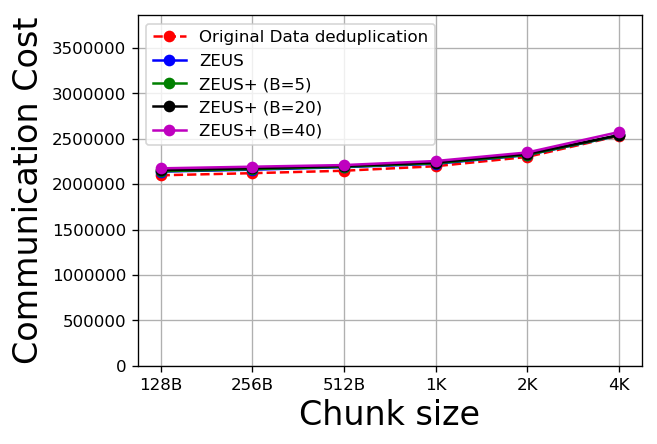

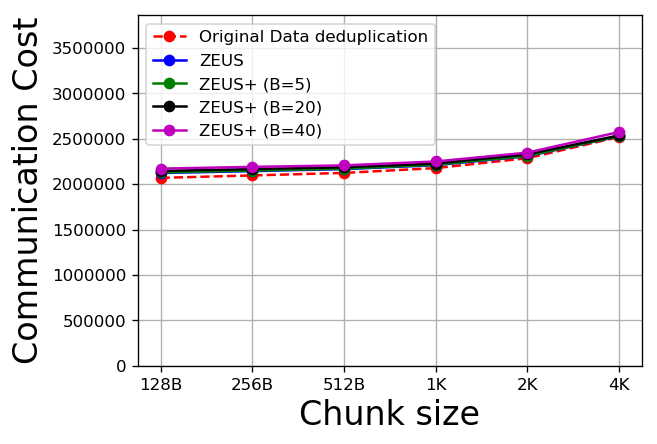

In [31]:
print("128 bytes result");
print("communication_cost_NormalDatadedpulication_1",communication_cost_NormalDatadedpulication_1_without, communication_cost_NormalDatadedpulication_1)   
print("communication_cost_rpx_1",communication_cost_rpx_1_without, communication_cost_rpx_1)
print("communication_cost_rpxPlus5_1",communication_cost_rpxPlus5_1_without, communication_cost_rpxPlus5_1)
print("communication_cost_rpxPlus10_1", communication_cost_rpxPlus10_1_without, communication_cost_rpxPlus10_1)
print("communication_cost_rpxPlus20_1",communication_cost_rpxPlus20_1_without, communication_cost_rpxPlus20_1)


print("256 bytes result");
print("communication_cost_NormalDatadedpulication_2",communication_cost_NormalDatadedpulication_2_without, communication_cost_NormalDatadedpulication_2)   
print("communication_cost_rpx_2",communication_cost_rpx_2_without, communication_cost_rpx_2)
print("communication_cost_rpxPlus5_2",communication_cost_rpxPlus5_2_without, communication_cost_rpxPlus5_2)
print("communication_cost_rpxPlus10_2", communication_cost_rpxPlus10_2_without, communication_cost_rpxPlus10_2)
print("communication_cost_rpxPlus20_2",communication_cost_rpxPlus20_2_without, communication_cost_rpxPlus20_2)

print("512 bytes result");
print("communication_cost_NormalDatadedpulication_3",communication_cost_NormalDatadedpulication_3_without, communication_cost_NormalDatadedpulication_3)   
print("communication_cost_rpx_3",communication_cost_rpx_3_without, communication_cost_rpx_3)
print("communication_cost_rpxPlus5_3",communication_cost_rpxPlus5_3_without, communication_cost_rpxPlus5_3)
print("communication_cost_rpxPlus10_3", communication_cost_rpxPlus10_3_without, communication_cost_rpxPlus10_3)
print("communication_cost_rpxPlus20_3",communication_cost_rpxPlus20_3_without, communication_cost_rpxPlus20_3)


print("1K bytes result");
print("communication_cost_NormalDatadedpulication_4",communication_cost_NormalDatadedpulication_4_without, communication_cost_NormalDatadedpulication_4)   
print("communication_cost_rpx_4",communication_cost_rpx_4_without, communication_cost_rpx_4)
print("communication_cost_rpxPlus5_4",communication_cost_rpxPlus5_4_without, communication_cost_rpxPlus5_4)
print("communication_cost_rpxPlus10_4", communication_cost_rpxPlus10_4_without, communication_cost_rpxPlus10_4)
print("communication_cost_rpxPlus20_4",communication_cost_rpxPlus20_4_without, communication_cost_rpxPlus20_4)


print("2K bytes result");
print("communication_cost_NormalDatadedpulication_5",communication_cost_NormalDatadedpulication_5_without, communication_cost_NormalDatadedpulication_5)   
print("communication_cost_rpx_5",communication_cost_rpx_5_without, communication_cost_rpx_5)
print("communication_cost_rpxPlus5_5",communication_cost_rpxPlus5_5_without, communication_cost_rpxPlus5_5)
print("communication_cost_rpxPlus10_5", communication_cost_rpxPlus10_5_without, communication_cost_rpxPlus10_5)
print("communication_cost_rpxPlus20_5",communication_cost_rpxPlus20_5_without, communication_cost_rpxPlus20_5)


print("4K bytes result");
print("communication_cost_NormalDatadedpulication_6",communication_cost_NormalDatadedpulication_6_without, communication_cost_NormalDatadedpulication_6)   
print("communication_cost_rpx_6",communication_cost_rpx_6_without, communication_cost_rpx_6)
print("communication_cost_rpxPlus5_6",communication_cost_rpxPlus5_6_without, communication_cost_rpxPlus5_6)
print("communication_cost_rpxPlus10_6", communication_cost_rpxPlus10_6_without, communication_cost_rpxPlus10_6)
print("communication_cost_rpxPlus20_6",communication_cost_rpxPlus20_6_without, communication_cost_rpxPlus20_6)


data1 = [communication_cost_NormalDatadedpulication_1, 
         communication_cost_NormalDatadedpulication_2, 
         communication_cost_NormalDatadedpulication_3,
         communication_cost_NormalDatadedpulication_4,
         communication_cost_NormalDatadedpulication_5,
         communication_cost_NormalDatadedpulication_6];
data2 = [communication_cost_rpx_1, 
         communication_cost_rpx_2, 
         communication_cost_rpx_3,
         communication_cost_rpx_4,
         communication_cost_rpx_5,
         communication_cost_rpx_6];
data3 = [communication_cost_rpxPlus5_1, 
         communication_cost_rpxPlus5_2, 
         communication_cost_rpxPlus5_3,
         communication_cost_rpxPlus5_4,
         communication_cost_rpxPlus5_5,
         communication_cost_rpxPlus5_6];
data4 = [communication_cost_rpxPlus10_1, 
         communication_cost_rpxPlus10_2, 
         communication_cost_rpxPlus10_3,
         communication_cost_rpxPlus10_4,
         communication_cost_rpxPlus10_5,
         communication_cost_rpxPlus10_6];
data5 = [communication_cost_rpxPlus20_1, 
         communication_cost_rpxPlus20_2, 
         communication_cost_rpxPlus20_3,
         communication_cost_rpxPlus20_4,
         communication_cost_rpxPlus20_5,
         communication_cost_rpxPlus20_6];
data1_array = np.array(data1)
data2_array = np.array(data2)
data3_array = np.array(data3)
data4_array = np.array(data4)
data5_array = np.array(data5)

max_data5_array = np.amax(data5_array)
#print(data1_array)
t = np.arange(len(data1_array))
print("length of t, ",len(t))
print("length of data1_array, ",len(data1_array))
plt.figure(dpi = 120)
plt.plot(t, data1_array, 'ro--', label='Original Data deduplication')
plt.plot(t, data2_array, 'bo-', label="ZEUS")
plt.plot(t, data3_array, 'go-', label="ZEUS+ (B=5)")
plt.plot(t, data4_array, 'ko-', label="ZEUS+ (B=20)")
plt.plot(t, data5_array, 'mo-', label="ZEUS+ (B=40)")
plt.legend()
my_xticks = ['128B','256B','512B','1K','2K','4K']
plt.xticks(t, my_xticks)
ax = plt.gca()
ax.set_ylim(0,max_data5_array*1.5)
#plt.autoscale()
#plt.tight_layout()
plt.gcf().subplots_adjust(left=0.20)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xlabel('Chunk size', fontsize=20)
plt.ylabel('Communication Cost',  fontsize=20)
#plt.title('About as simple as it gets, folks')
plt.grid(True)
# plt.savefig("deduplication.eps")



data1_without = [communication_cost_NormalDatadedpulication_1_without, 
         communication_cost_NormalDatadedpulication_2_without, 
         communication_cost_NormalDatadedpulication_3_without,
         communication_cost_NormalDatadedpulication_4_without,
         communication_cost_NormalDatadedpulication_5_without,
         communication_cost_NormalDatadedpulication_6_without];
data2_without = [communication_cost_rpx_1_without, 
         communication_cost_rpx_2_without, 
         communication_cost_rpx_3_without,
         communication_cost_rpx_4_without,
         communication_cost_rpx_5_without,
         communication_cost_rpx_6_without];
data3_without = [communication_cost_rpxPlus5_1_without, 
         communication_cost_rpxPlus5_2_without, 
         communication_cost_rpxPlus5_3_without,
         communication_cost_rpxPlus5_4_without,
         communication_cost_rpxPlus5_5_without,
         communication_cost_rpxPlus5_6_without];
data4_without = [communication_cost_rpxPlus10_1_without, 
         communication_cost_rpxPlus10_2_without, 
         communication_cost_rpxPlus10_3_without,
         communication_cost_rpxPlus10_4_without,
         communication_cost_rpxPlus10_5_without,
         communication_cost_rpxPlus10_6_without];
data5_without = [communication_cost_rpxPlus20_1_without, 
         communication_cost_rpxPlus20_2_without, 
         communication_cost_rpxPlus20_3_without,
         communication_cost_rpxPlus20_4_without,
         communication_cost_rpxPlus20_5_without,
         communication_cost_rpxPlus20_6_without];
data1_array_without = np.array(data1_without)
data2_array_without = np.array(data2_without)
data3_array_without = np.array(data3_without)
data4_array_without = np.array(data4_without)
data5_array_without = np.array(data5_without)

max_data5_array = np.amax(data5_array)
#print(data1_array)
t_without = np.arange(len(data1_array_without))
print("length of t, ",len(t_without))
print("length of data1_array, ",len(data1_array_without))
plt.figure(dpi = 120)
plt.plot(t_without, data1_array_without, 'ro--', label='Original Data deduplication')
plt.plot(t_without, data2_array_without, 'bo-', label="ZEUS")
plt.plot(t_without, data3_array_without, 'go-', label="ZEUS+ (B=5)")
plt.plot(t_without, data4_array_without, 'ko-', label="ZEUS+ (B=20)")
plt.plot(t_without, data5_array_without, 'mo-', label="ZEUS+ (B=40)")
plt.legend()
my_xticks_without = ['128B','256B','512B','1K','2K','4K']
plt.xticks(t, my_xticks_without)
ax = plt.gca()
ax.set_ylim(0,max_data5_array*1.5)
#plt.autoscale()
#plt.tight_layout()
plt.gcf().subplots_adjust(left=0.20)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xlabel('Chunk size', fontsize=20)
plt.ylabel('Communication Cost',  fontsize=20)
#plt.title('About as simple as it gets, folks')
plt.grid(True)
# plt.savefig("deduplication_without.eps")

plt.show()

In [32]:
print(len(Data_size_1))

17075
